In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
class VisBean:
    def __init__(self, token_name, mean, eigs, projection):
        self._token_name= token_name
        self._mean = mean
        self._eigs = eigs
        self._projection = projection
        self._k = np.shape(self._eigs)[0]
        
    def __str__(self):
        return self._token_name

    def get_reconstruction(self):
        Eig = np.matrix(self._eigs)
        rec = np.array(self._projection * Eig + self._mean)
        return np.ravel(rec)


# parse data
years = [2008, 2009, 2010, 2011, 2013, 2014, 2015]
partitions = ['weekday', 'weekend']
projection_columns = [2, 3, 4, 5, 6]
#
base = './data/{}'
year_partition_key_format = '{}_{}'  # year_partition
mean_filename_format = 'total_flow_{}_mean_vector.pivot_{}_grouping_pca_tmp.csv'
eigs_filename_format = 'total_flow_{}_eigenvectors.pivot_{}_grouping_pca_tmp.csv'
eig_values_filename_format = 'total_flow_{}_eigenvalues.pivot_{}_grouping_pca_tmp.csv'
station_filename_format = 'total_flow_{}_transformed.pivot_{}_grouping.csv'
#
visbeans = {}
station_partitions= {}
means= {}
eig_values= {}
eigs_map= {}
for year in years:
    for partition in partitions:
        mean_filename = '/'.join([base.format(partition), mean_filename_format.format(partition, year)])
        eigs_filename = '/'.join([base.format(partition), eigs_filename_format.format(partition, year)])
        eig_values_filename = '/'.join([base.format(partition), eig_values_filename_format.format(partition, year)])
        station_filename = '/'.join([base.format(partition), station_filename_format.format(partition, year)])
        #
        mean = pd.read_csv(mean_filename, header=None).values[0]
        eigs = pd.read_csv(eigs_filename, header=None).values.T  # eigenvectors per row matrix (5 X 288)
        ev = pd.read_csv(eig_values_filename, header=None).values[0]
        stations_df = pd.read_csv(station_filename, header=None)
        #
        year_partition_key= year_partition_key_format.format(year, partition)
        means[year_partition_key]= mean
        eig_values[year_partition_key]= ev
        eigs_map[year_partition_key]= eigs
        #
        stations_list= []
        for _, row in stations_df.iterrows():
            station_id = int(row[0])
            projection = row[projection_columns].values
            #
            stations_list.append(str(station_id))
            #
            visbean = VisBean(year_partition_key, mean, eigs, projection)
            #
            vis_list= []
            if station_id in visbeans:
                vis_list= visbeans[station_id]
            else:
                visbeans[station_id]= vis_list
            vis_list.append(visbean)
        station_partitions[year_partition_key]= sorted(stations_list, key=lambda k: int(k))

In [4]:
def set_xaxis(ax, n_x):
    x_ticks_major= []
    x_ticks_minor= []
    x_labels_minor= []
    x_labels_major= []
    m_empty_string= ''
    for i in xrange(n_x):
        m_time_minute= 5 * (i + 1)
        m_minute_string= '{}M'.format(m_time_minute).zfill(5)
        if m_time_minute % 60 == 0:
            m_hour= m_time_minute / 60
            m_hour_string= '{}H'.format(m_hour).zfill(3)
            x_ticks_major.append(float(i))
            x_labels_major.append(m_hour_string)
        else:
            x_ticks_minor.append(float(i))
            x_labels_minor.append(m_minute_string)
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_xticks(x_ticks_major, minor=False)
    ax.set_xticklabels(x_labels_major, minor=False, rotation=65)
    ax.grid(True, which='major')

In [5]:
figsize= (16,8)

# Mean Vector

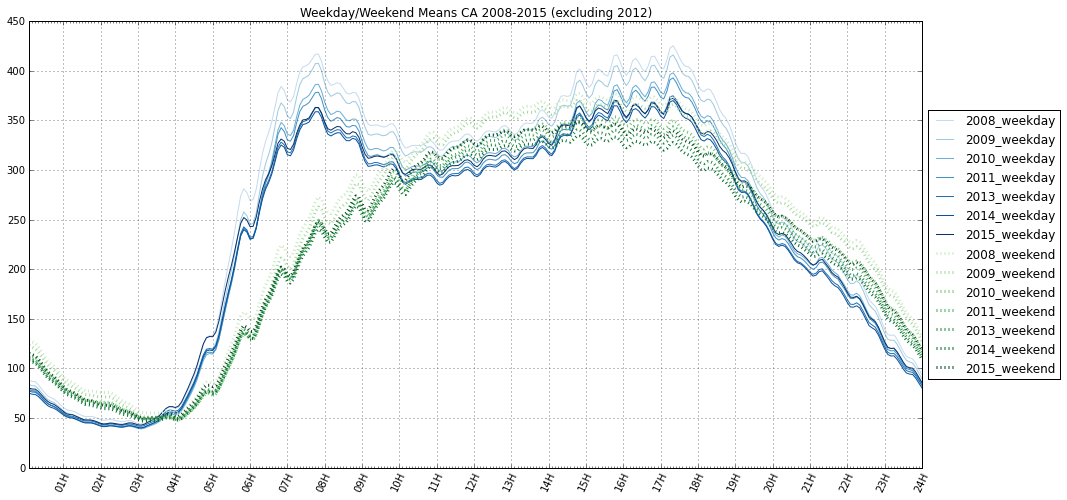

In [6]:
mean_keys= sorted(means.keys())
weekday_colors= ['#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b'] # blue
weekend_colors= ['#c7e9c0', '#a1d99b', '#74c476', '#41ab5d', '#238b45', '#006d2c', '#00441b'] # green
weekday_keys= []
weekday_values= []
weekend_keys= []
weekend_values= []
for i in xrange(0, len(mean_keys), 2):
    weekday_key= mean_keys[i]
    weekend_key= mean_keys[i + 1]
    #
    v_weekday= means[weekday_key]
    v_weekend= means[weekend_key]
    #
    weekday_keys.append(weekday_key)
    weekend_keys.append(weekend_key)
    weekday_values.append(v_weekday)
    weekend_values.append(v_weekend)

fig, ax= plt.subplots(figsize=figsize)
set_xaxis(ax, len(weekday_values[0]))
ax.set_title("Weekday/Weekend Means CA 2008-2015 (excluding 2012)")
for c, k, v in zip(weekday_colors, weekday_keys, weekday_values):
    ax.plot(v, c=c, label=k, ls='-', lw=1.0) # blue
for c, k, v in zip(weekend_colors, weekend_keys, weekend_values):
    ax.plot(v, c=c, label=k, ls=':', lw=3.0) # green
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Perc. Variance Explained

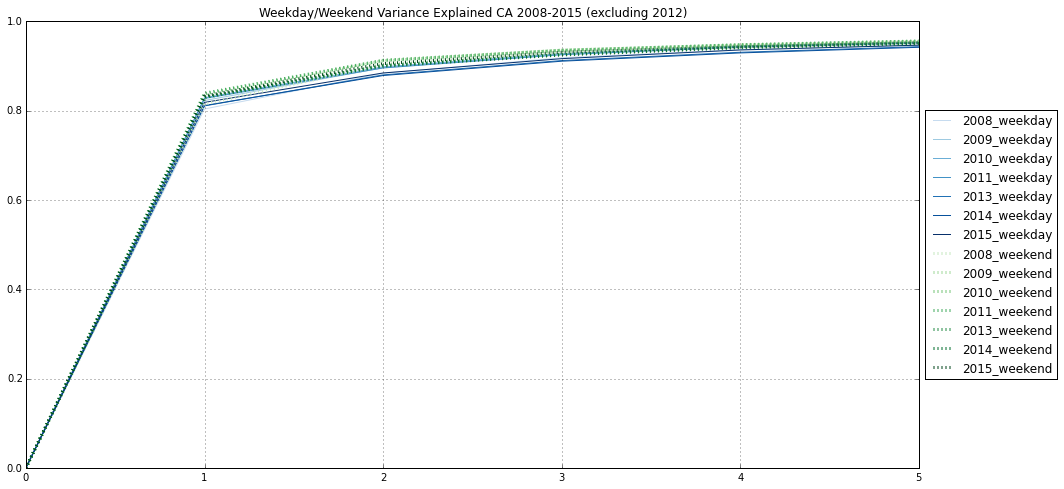

In [7]:
k= 5
ev_keys= sorted(eig_values.keys())
weekday_colors= ['#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b'] # blue
weekend_colors= ['#c7e9c0', '#a1d99b', '#74c476', '#41ab5d', '#238b45', '#006d2c', '#00441b'] # green
weekday_keys= []
weekday_values= []
weekend_keys= []
weekend_values= []
for i in xrange(0, len(eig_values), 2):
    weekday_key= ev_keys[i]
    weekend_key= ev_keys[i + 1]
    #
    v_weekday= eig_values[weekday_key]
    v_weekend= eig_values[weekend_key]
    v_weekday = ([0, ] + list(np.cumsum(v_weekday[:k])))
    v_weekend = ([0, ] + list(np.cumsum(v_weekend[:k])))
    #
    weekday_keys.append(weekday_key)
    weekend_keys.append(weekend_key)
    weekday_values.append(v_weekday)
    weekend_values.append(v_weekend)

fig, ax= plt.subplots(figsize=figsize)
ax.set_title("Weekday/Weekend Variance Explained CA 2008-2015 (excluding 2012)")
ax.grid()
for c, k, v in zip(weekday_colors, weekday_keys, weekday_values):
    ax.plot(v, c=c, label=k, ls='-', lw=1.0) # blue
for c, k, v in zip(weekend_colors, weekend_keys, weekend_values):
    ax.plot(v, c=c, label=k, ls=':', lw=3.0) # green
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Top Eigenvectors

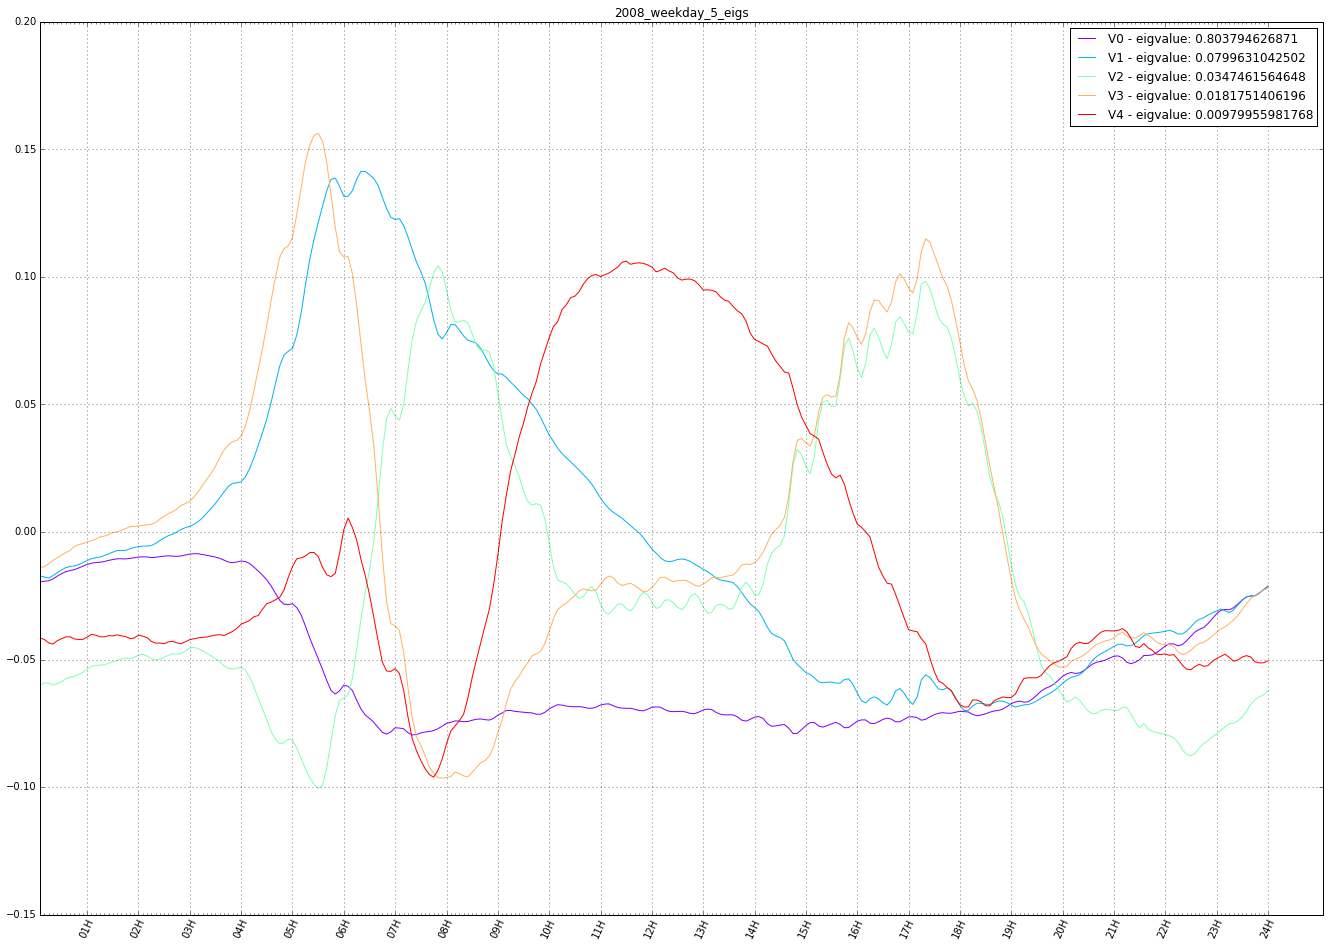

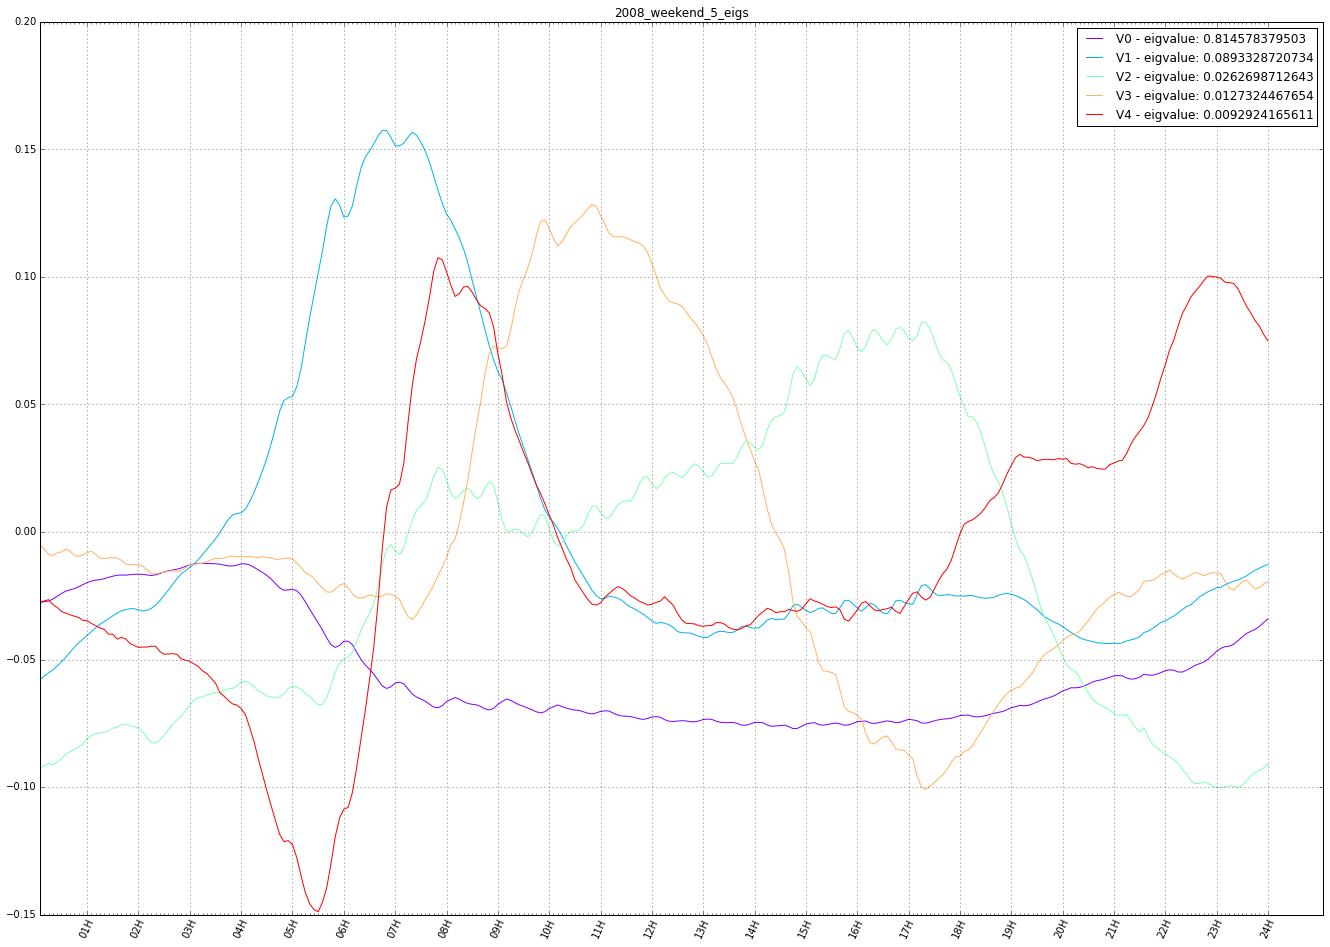

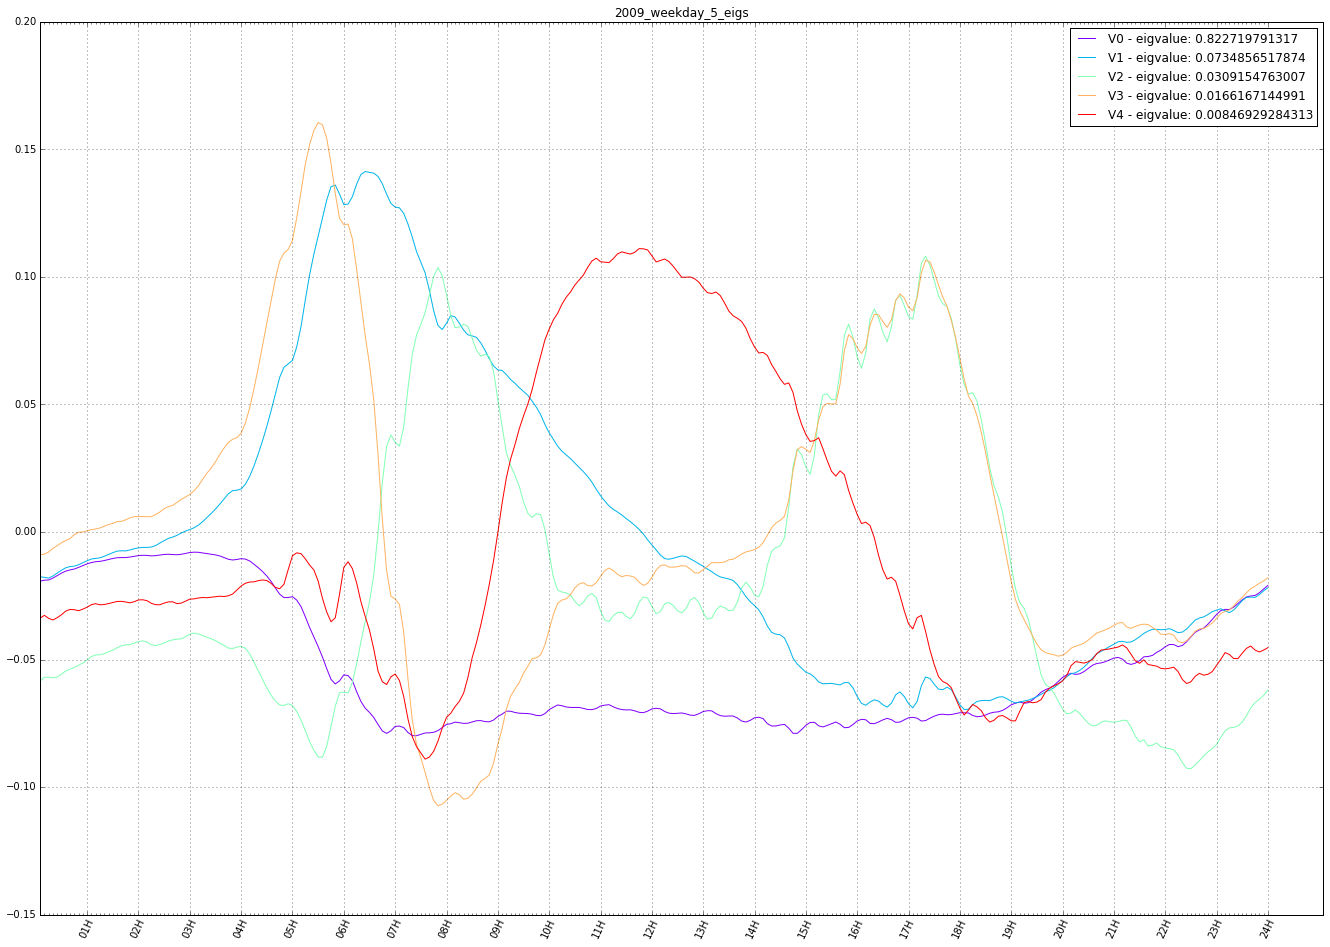

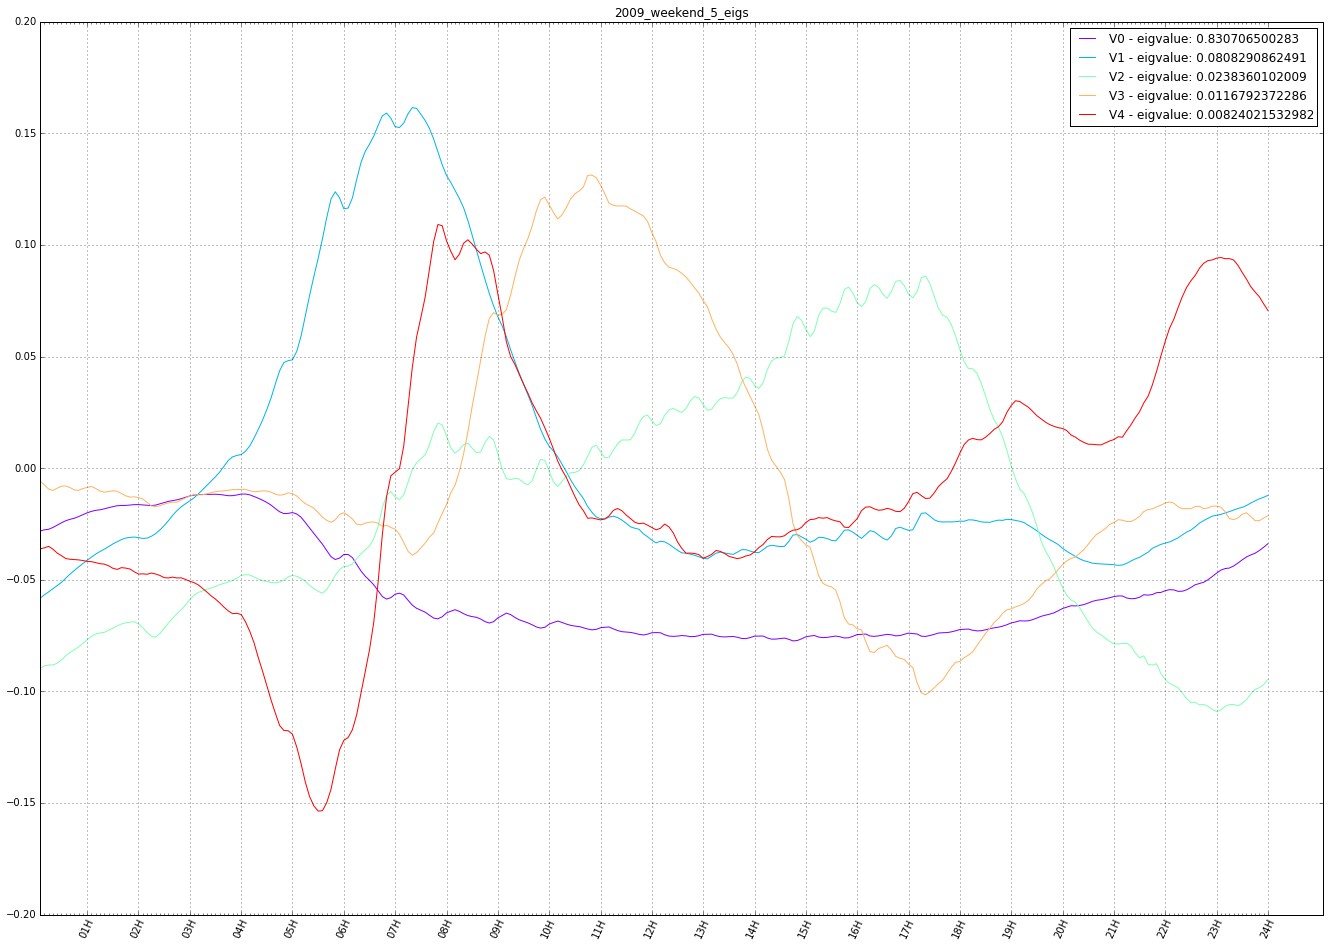

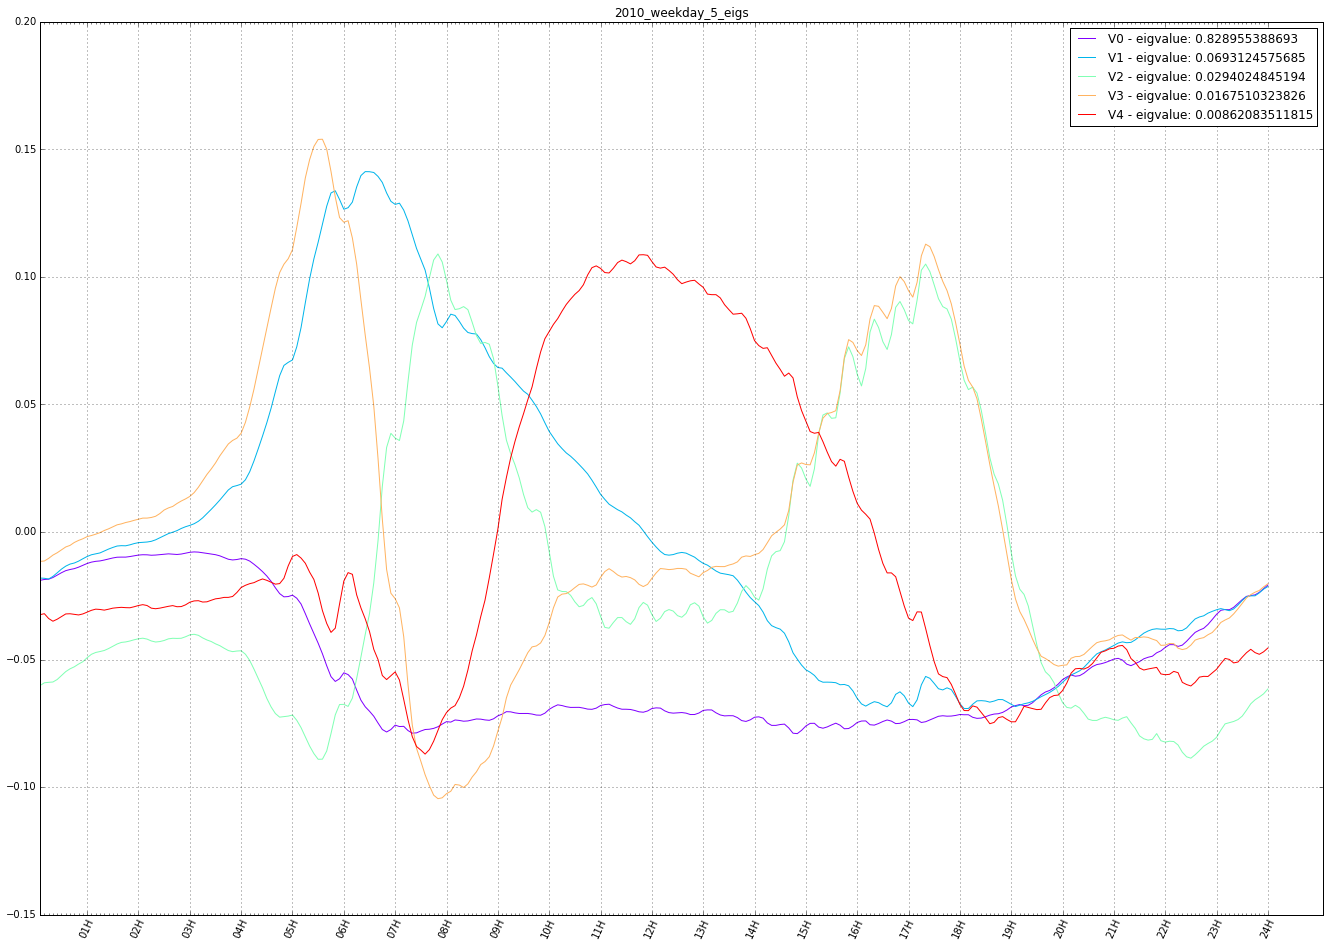

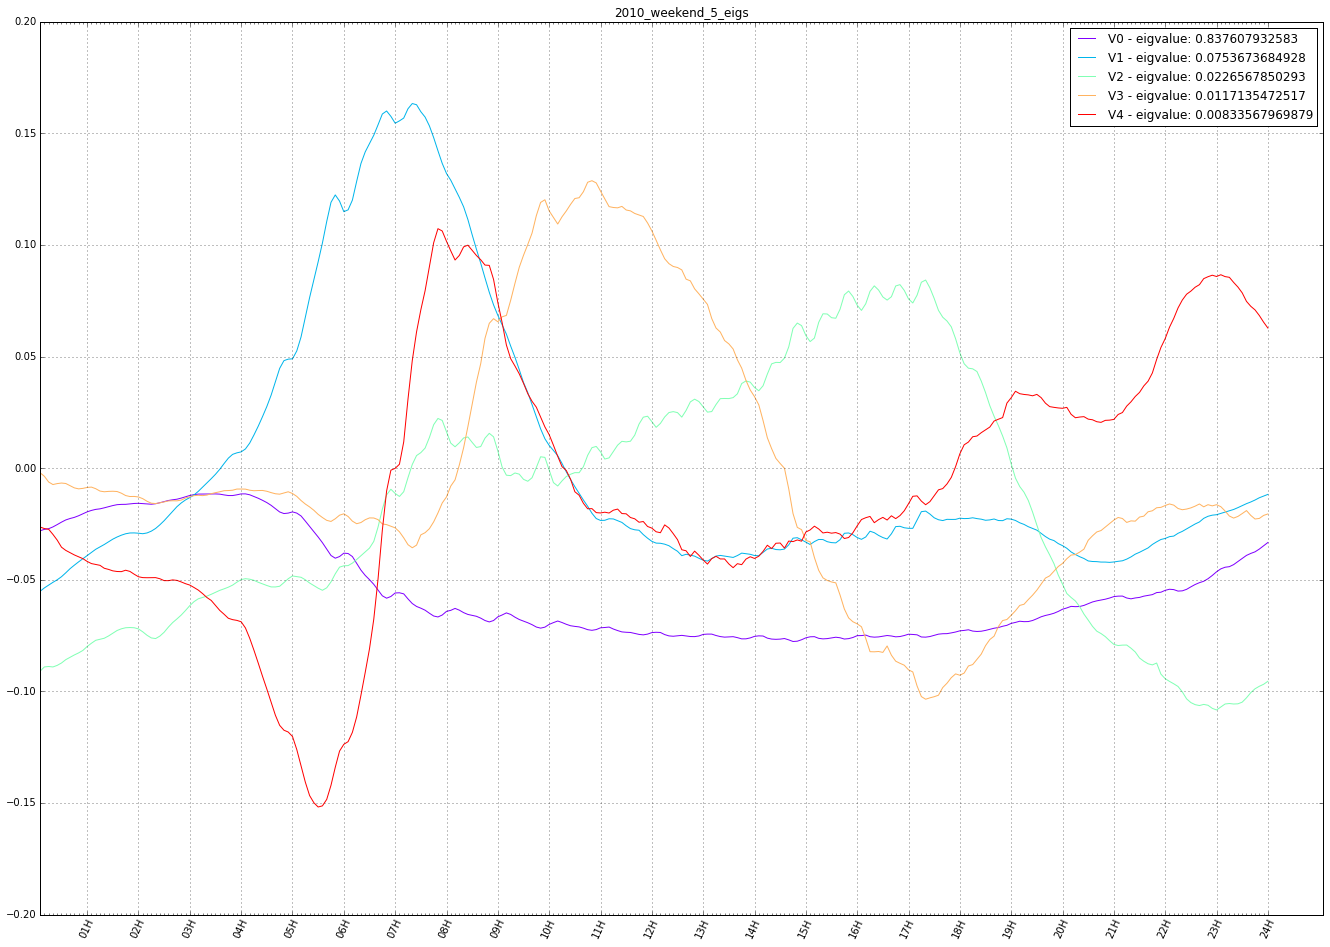

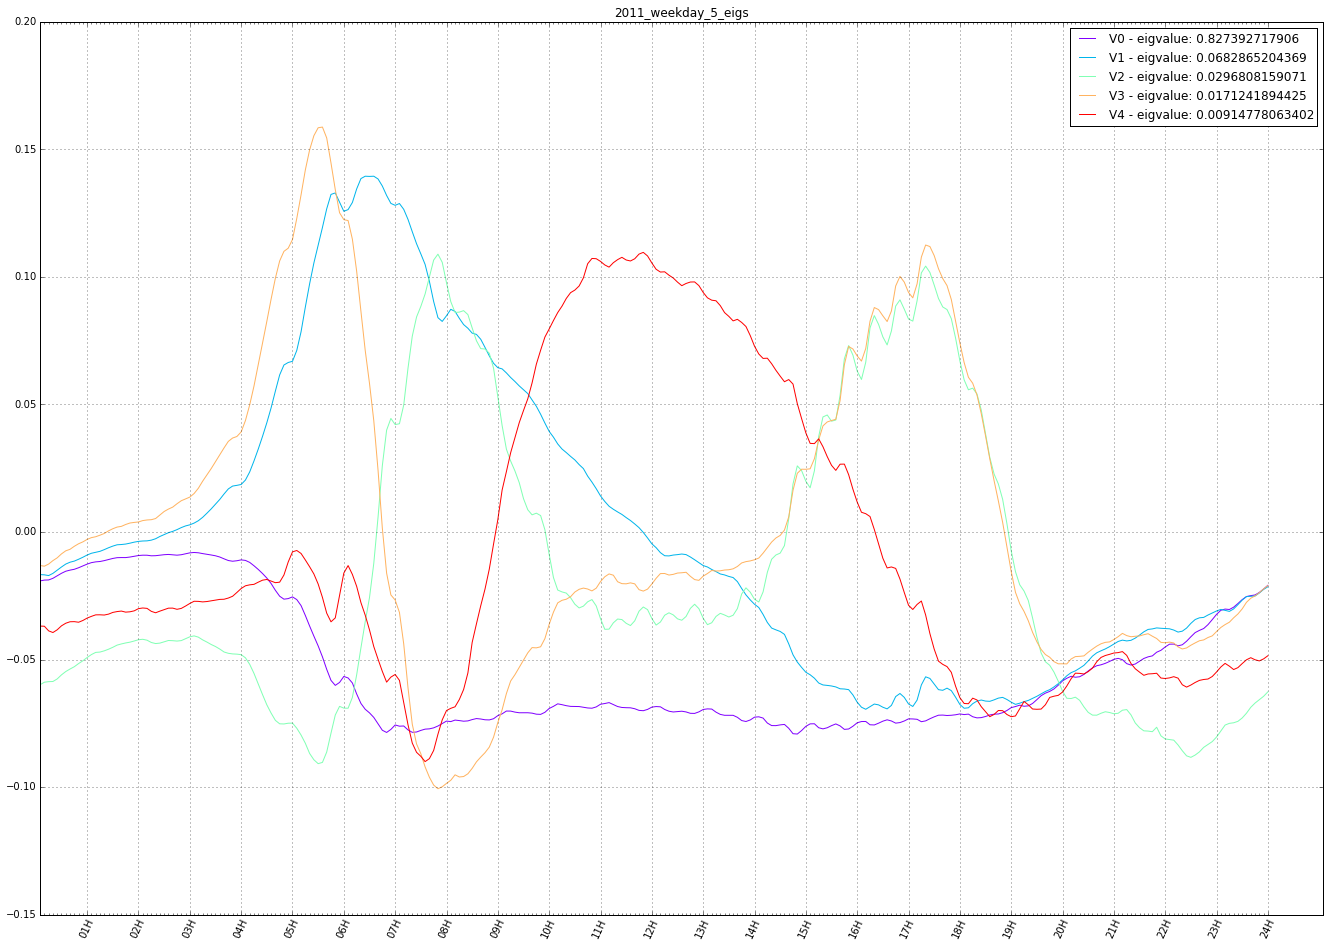

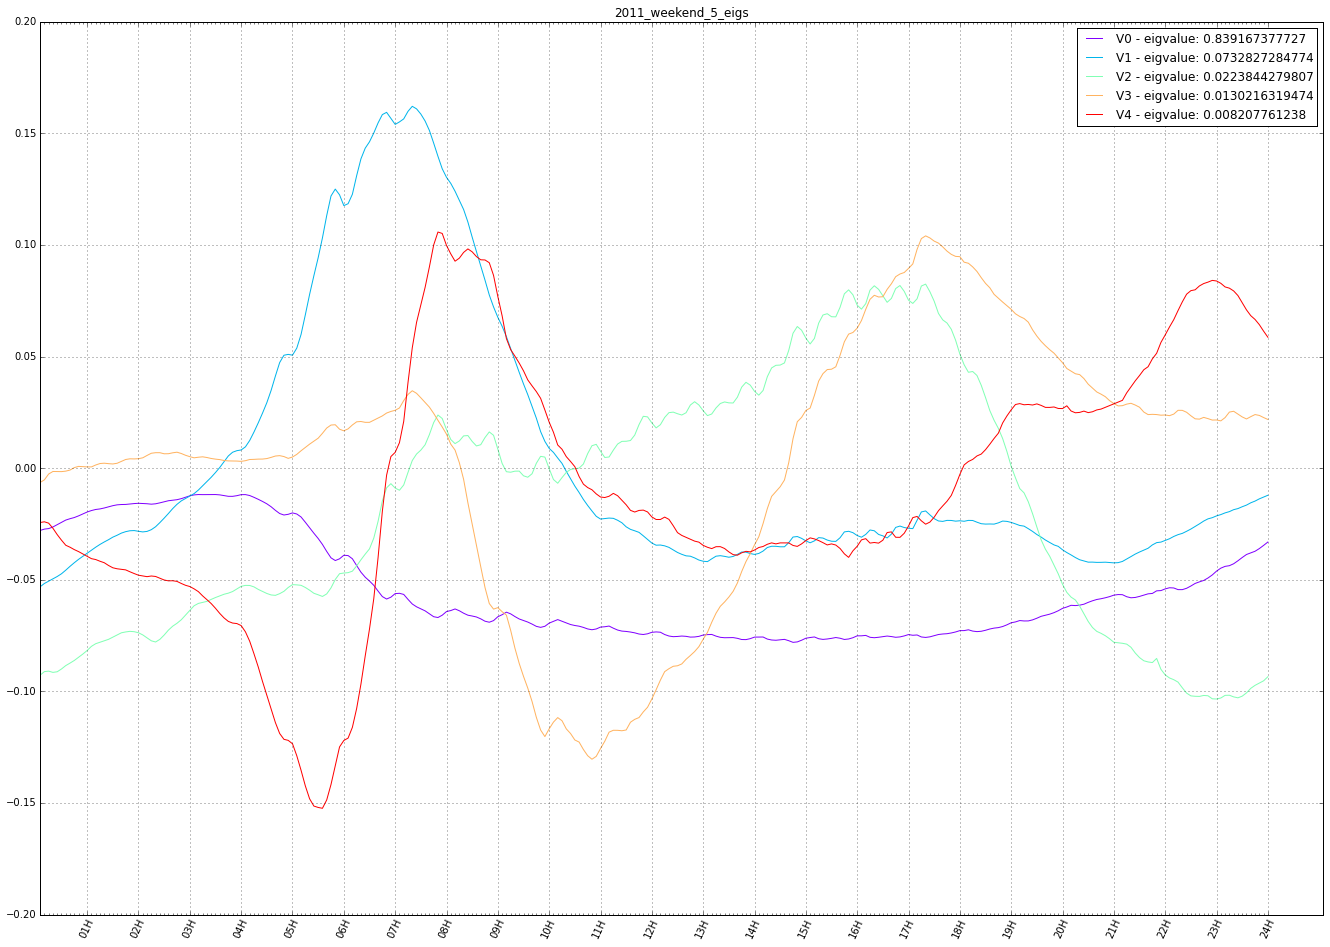

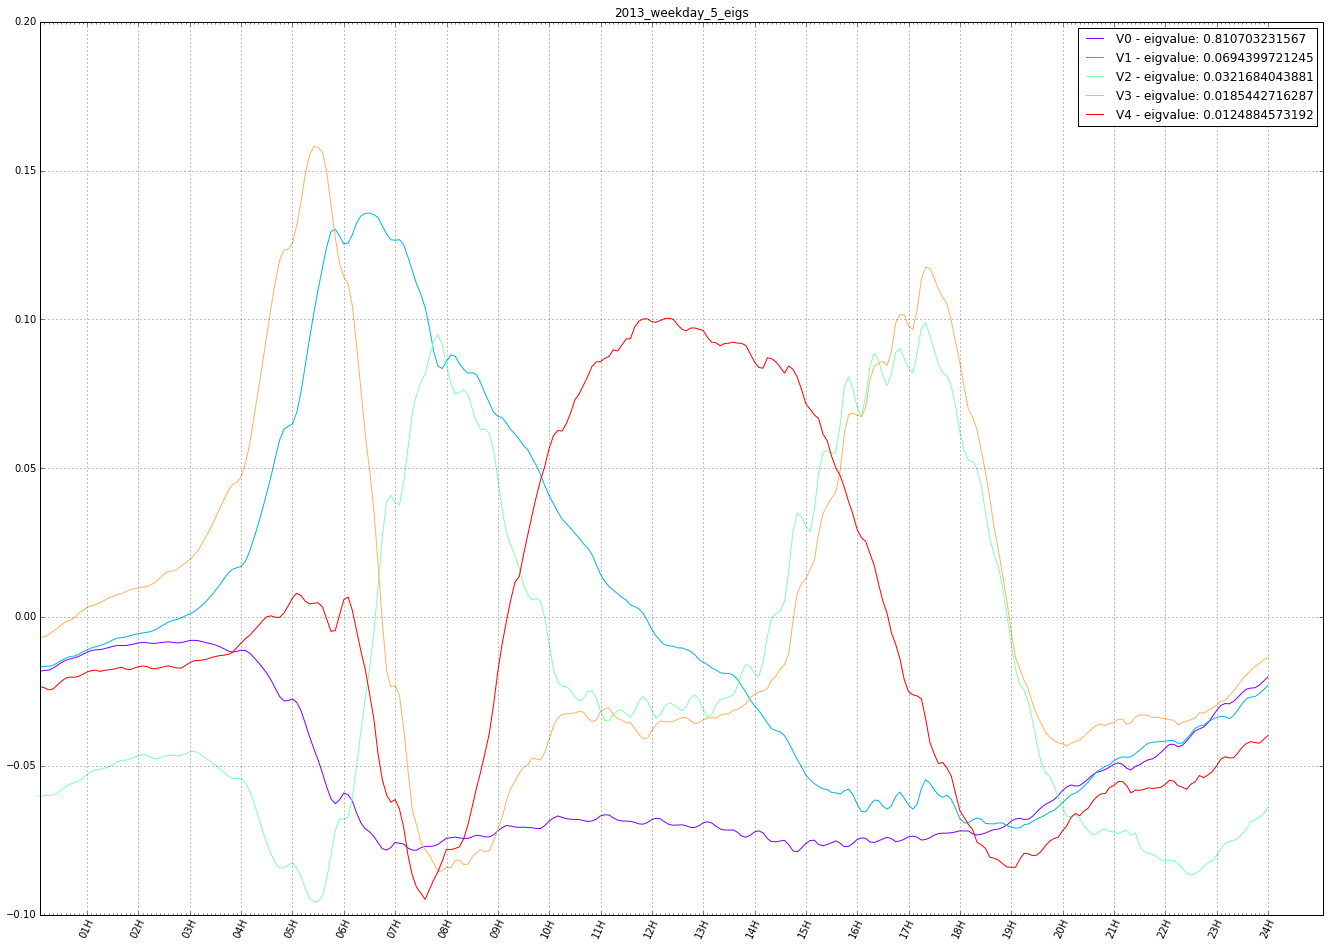

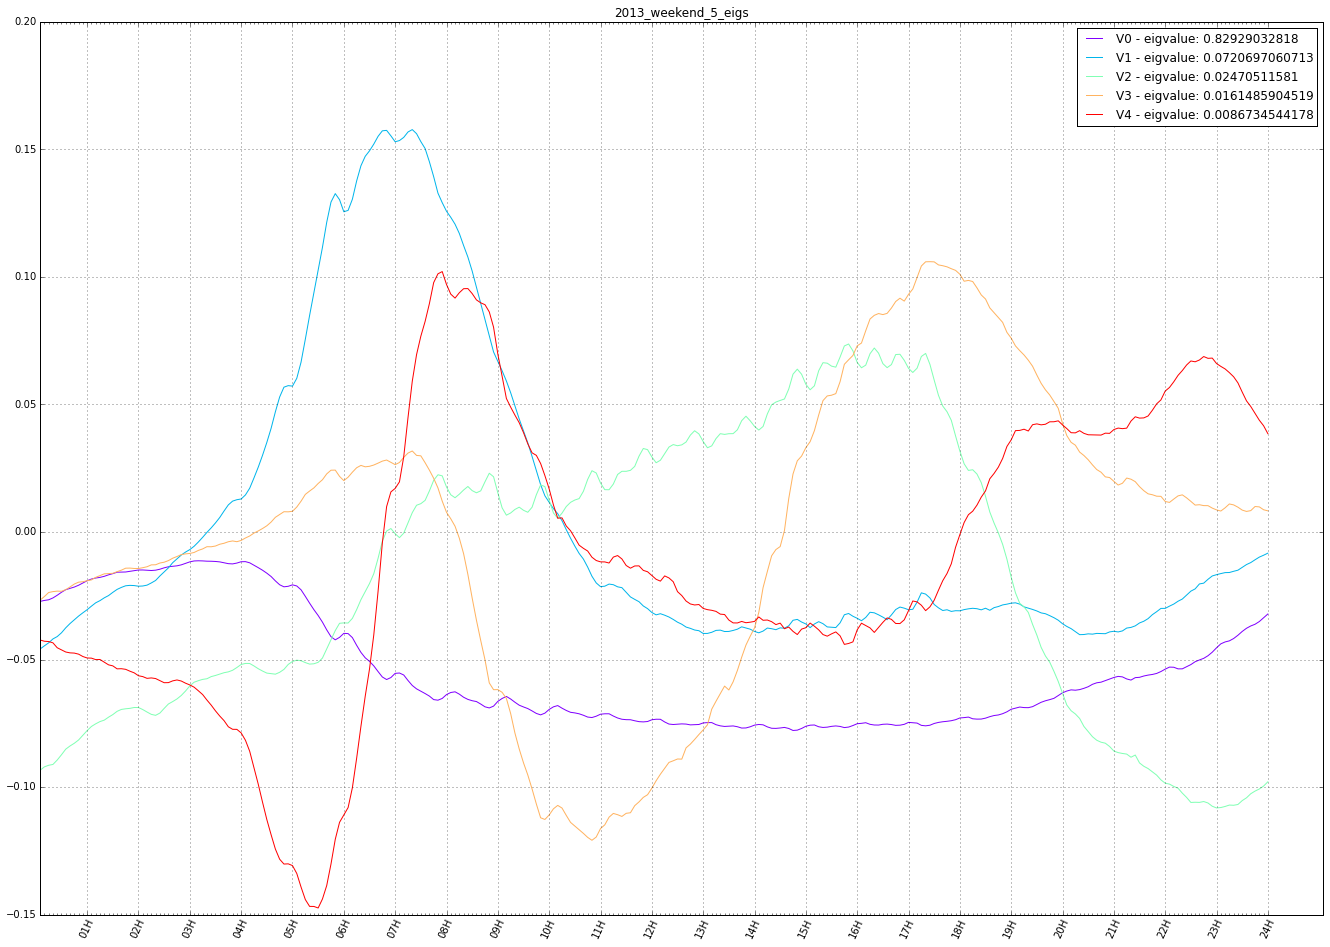

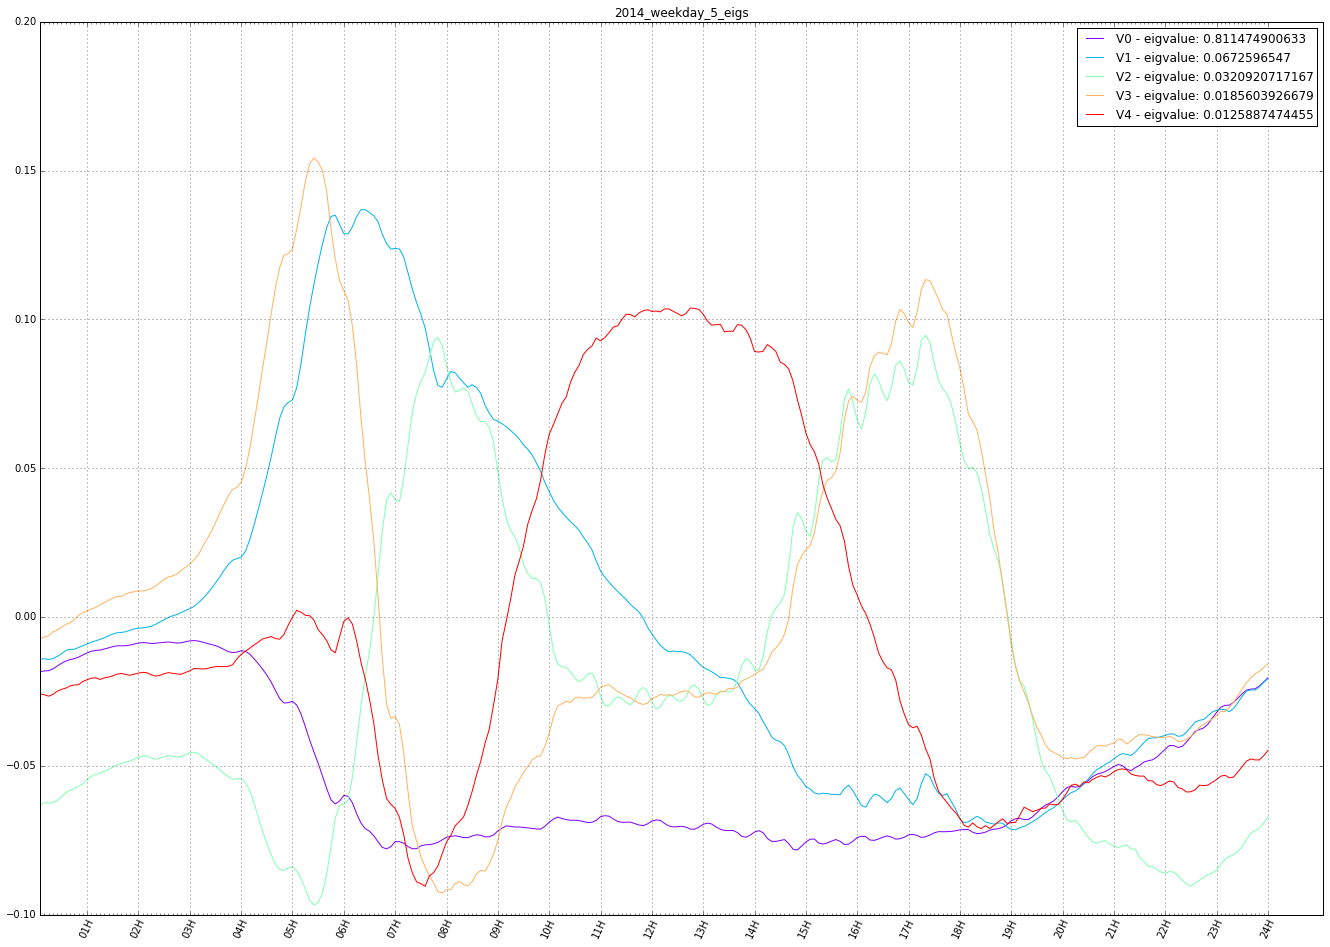

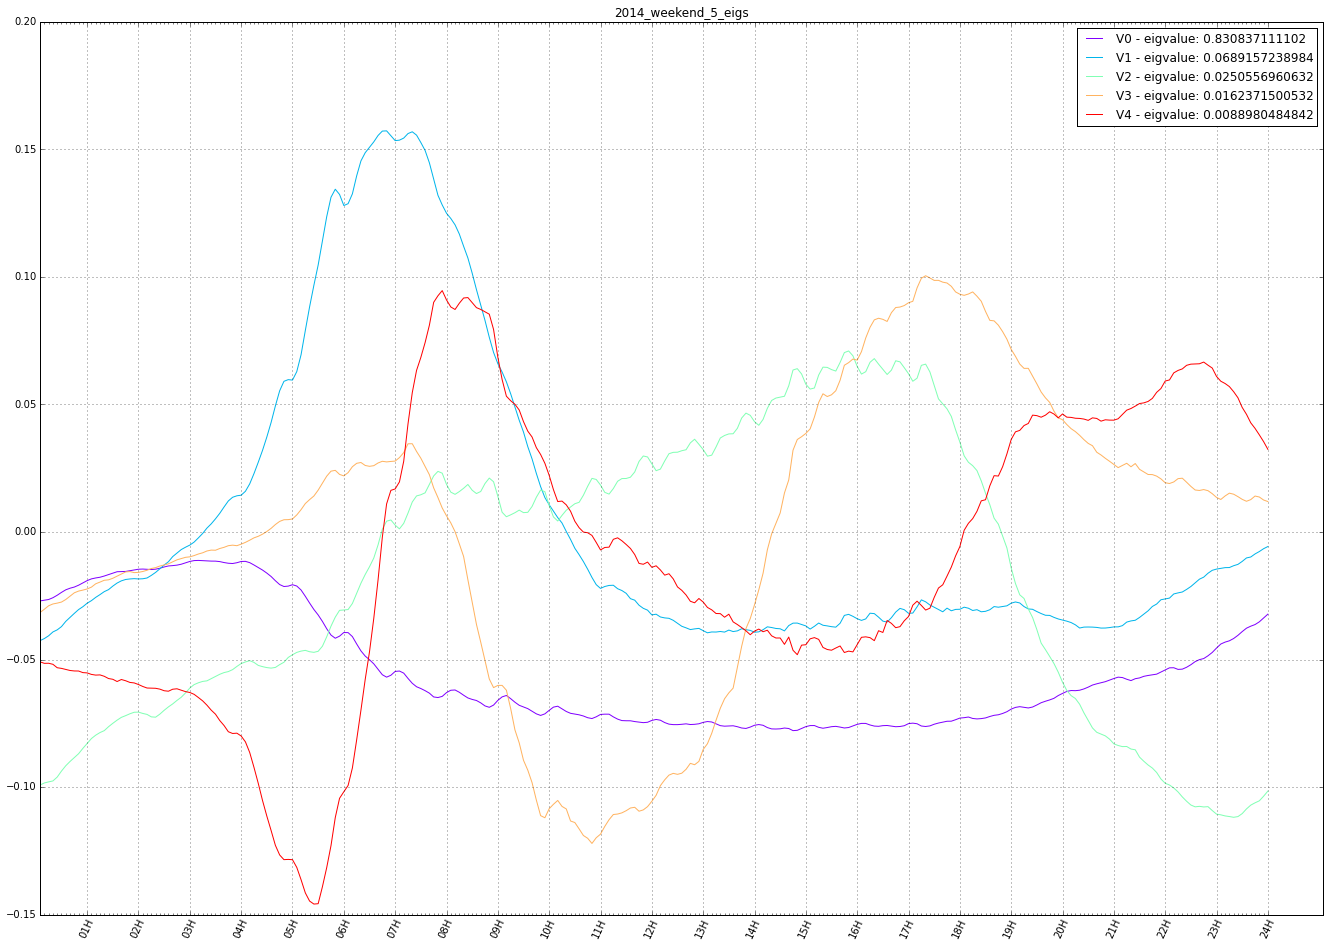

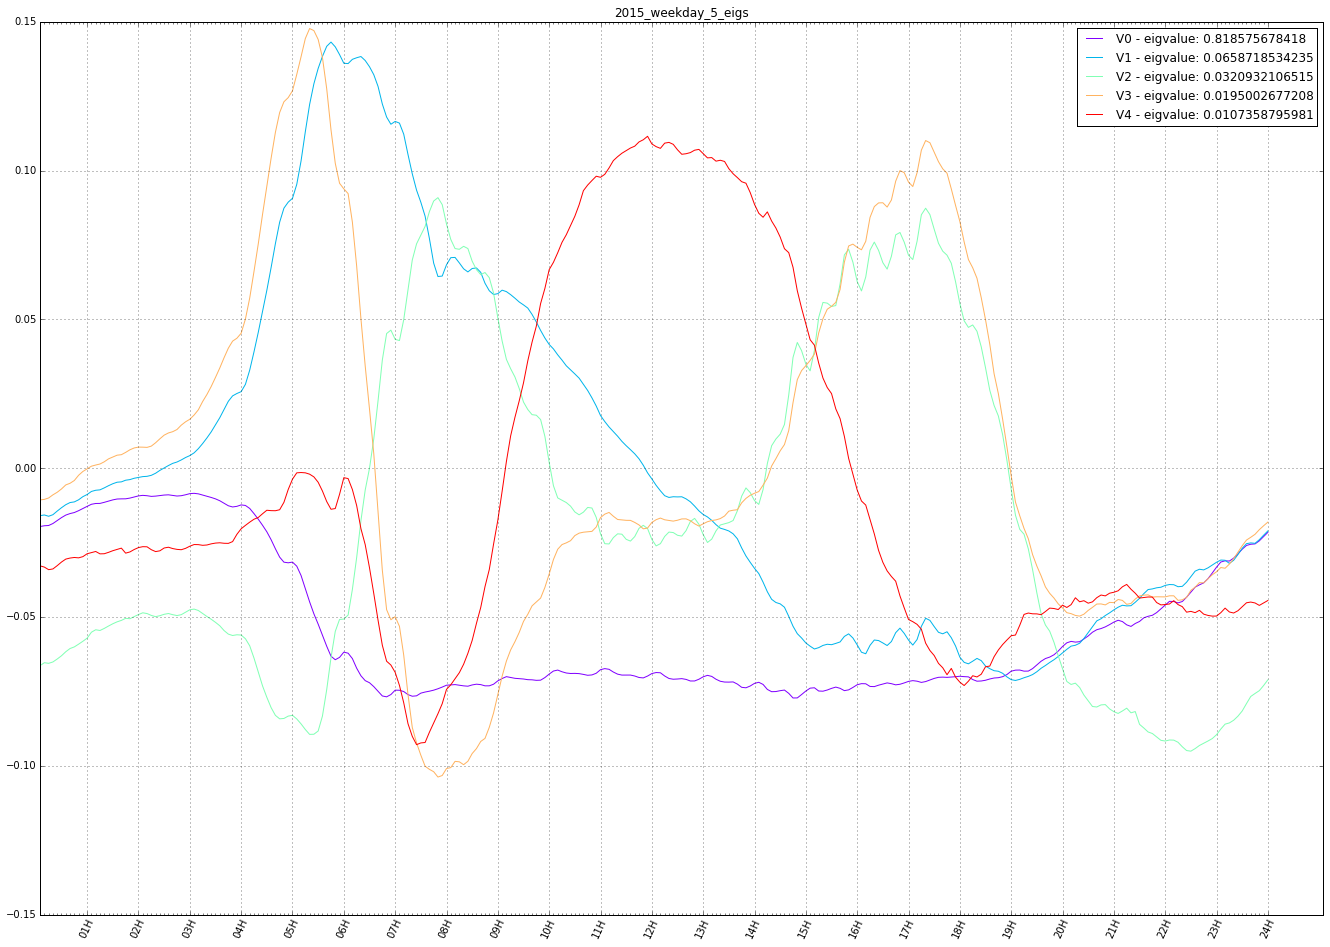

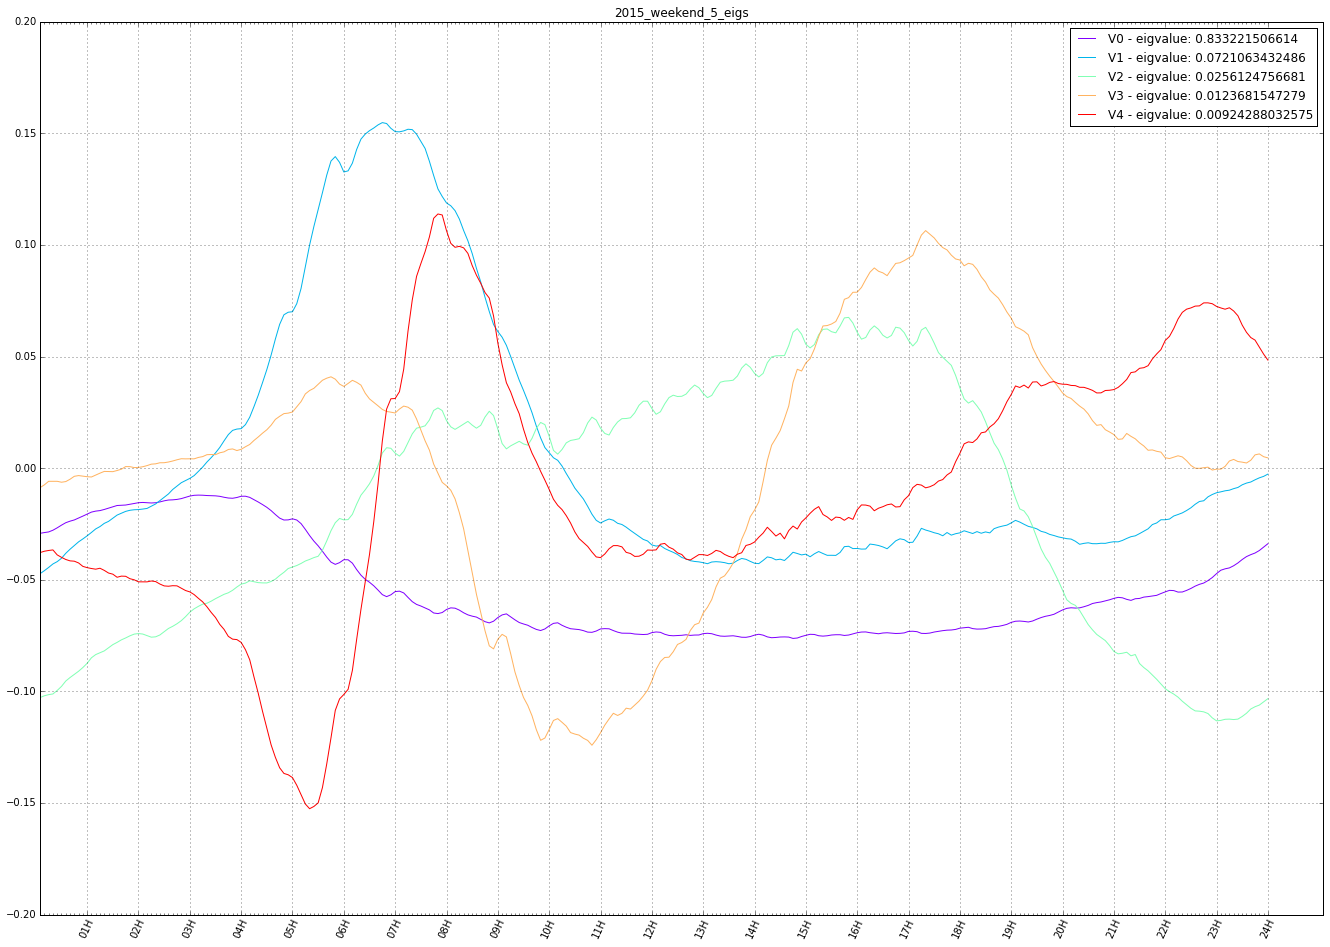

In [8]:
from matplotlib.pyplot import cm

eigs_keys= sorted(eigs_map.keys())
ev_keys= sorted(eig_values.keys())
n= 5
for ek, ev in zip(eigs_keys, ev_keys):
    m_eigs= eigs_map[ek]
    m_eig_values= eig_values[ev]
    #
    colors=cm.rainbow(np.linspace(0,1,n))

    width= 23
    height= 16
    fig, ax= plt.subplots(figsize=(width,height))
    l_x= [i for i in xrange(shape(m_eigs)[1])]
    for i in xrange(n):
        l_y= m_eigs[i]
        m_eig_value= m_eig_values[i]
        m_label= 'V{} - eigvalue: {}'.format(i, m_eig_value)
        ax.plot(l_x, l_y, color=colors[i], label=m_label)
    ax.legend()
    m_title= ek + '_5_eigs'
    ax.set_title(m_title)
    set_xaxis(ax, shape(m_eigs)[1])

# Reconstruction on Top Eigenvectors

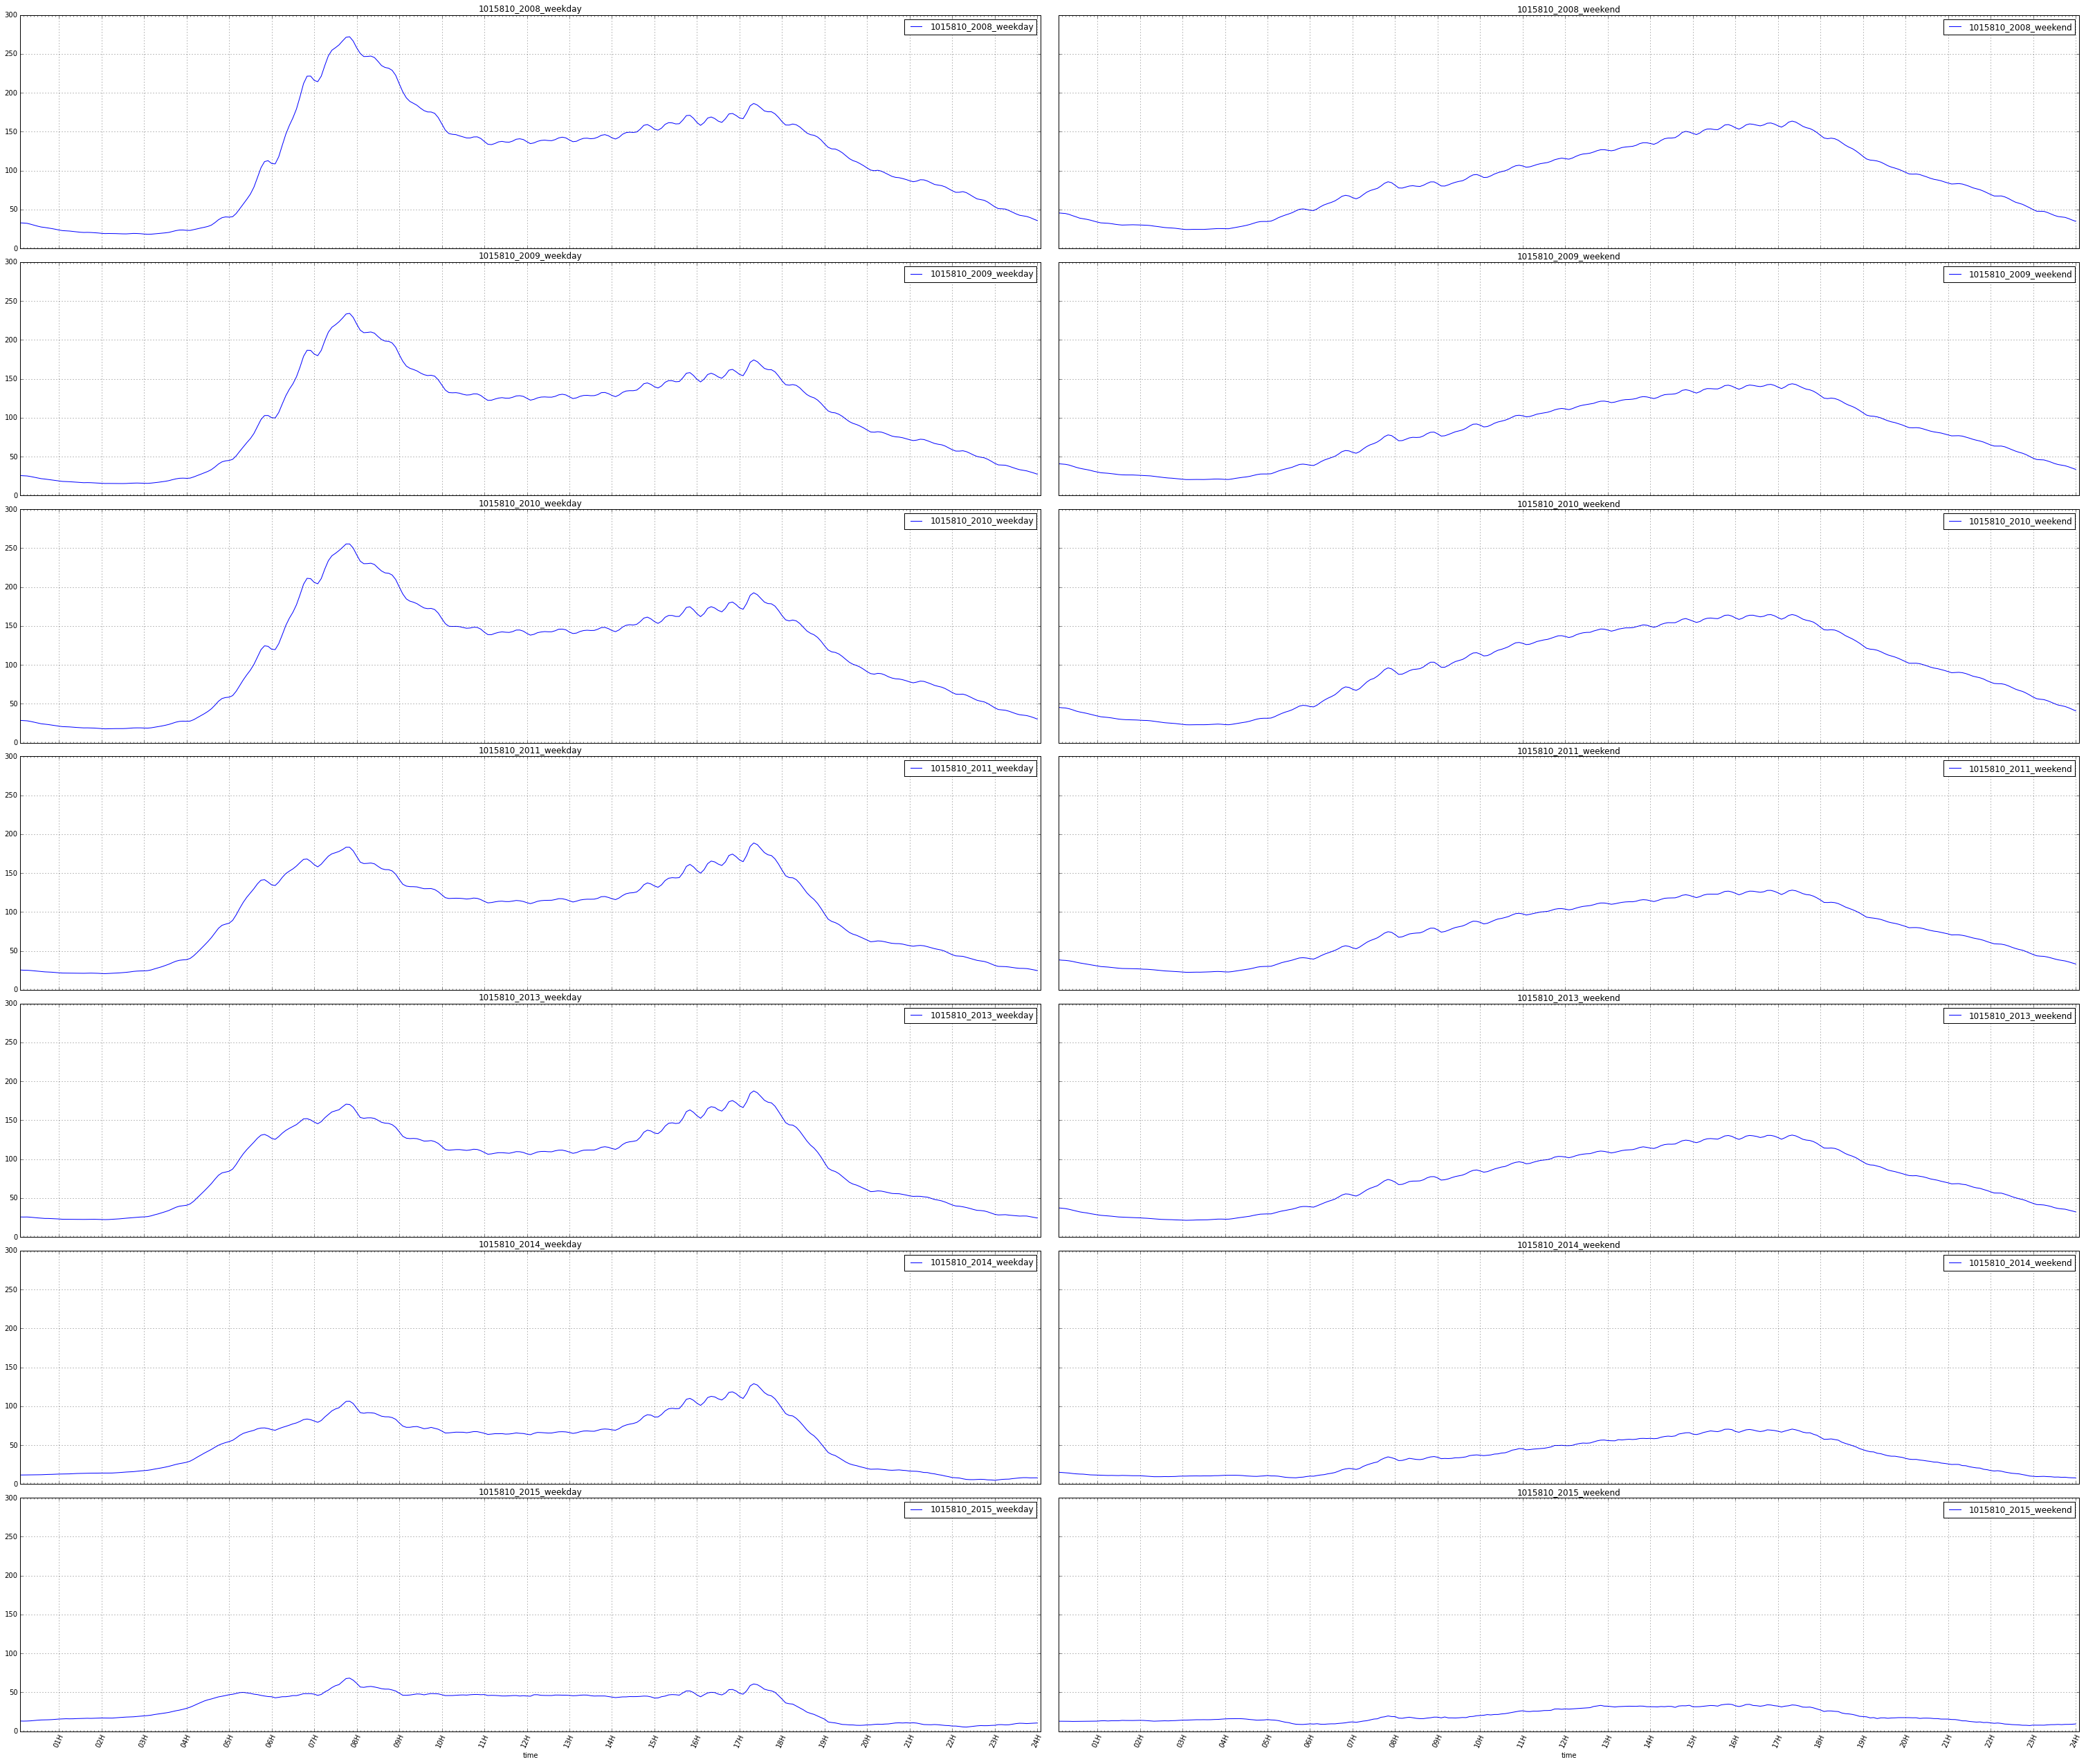

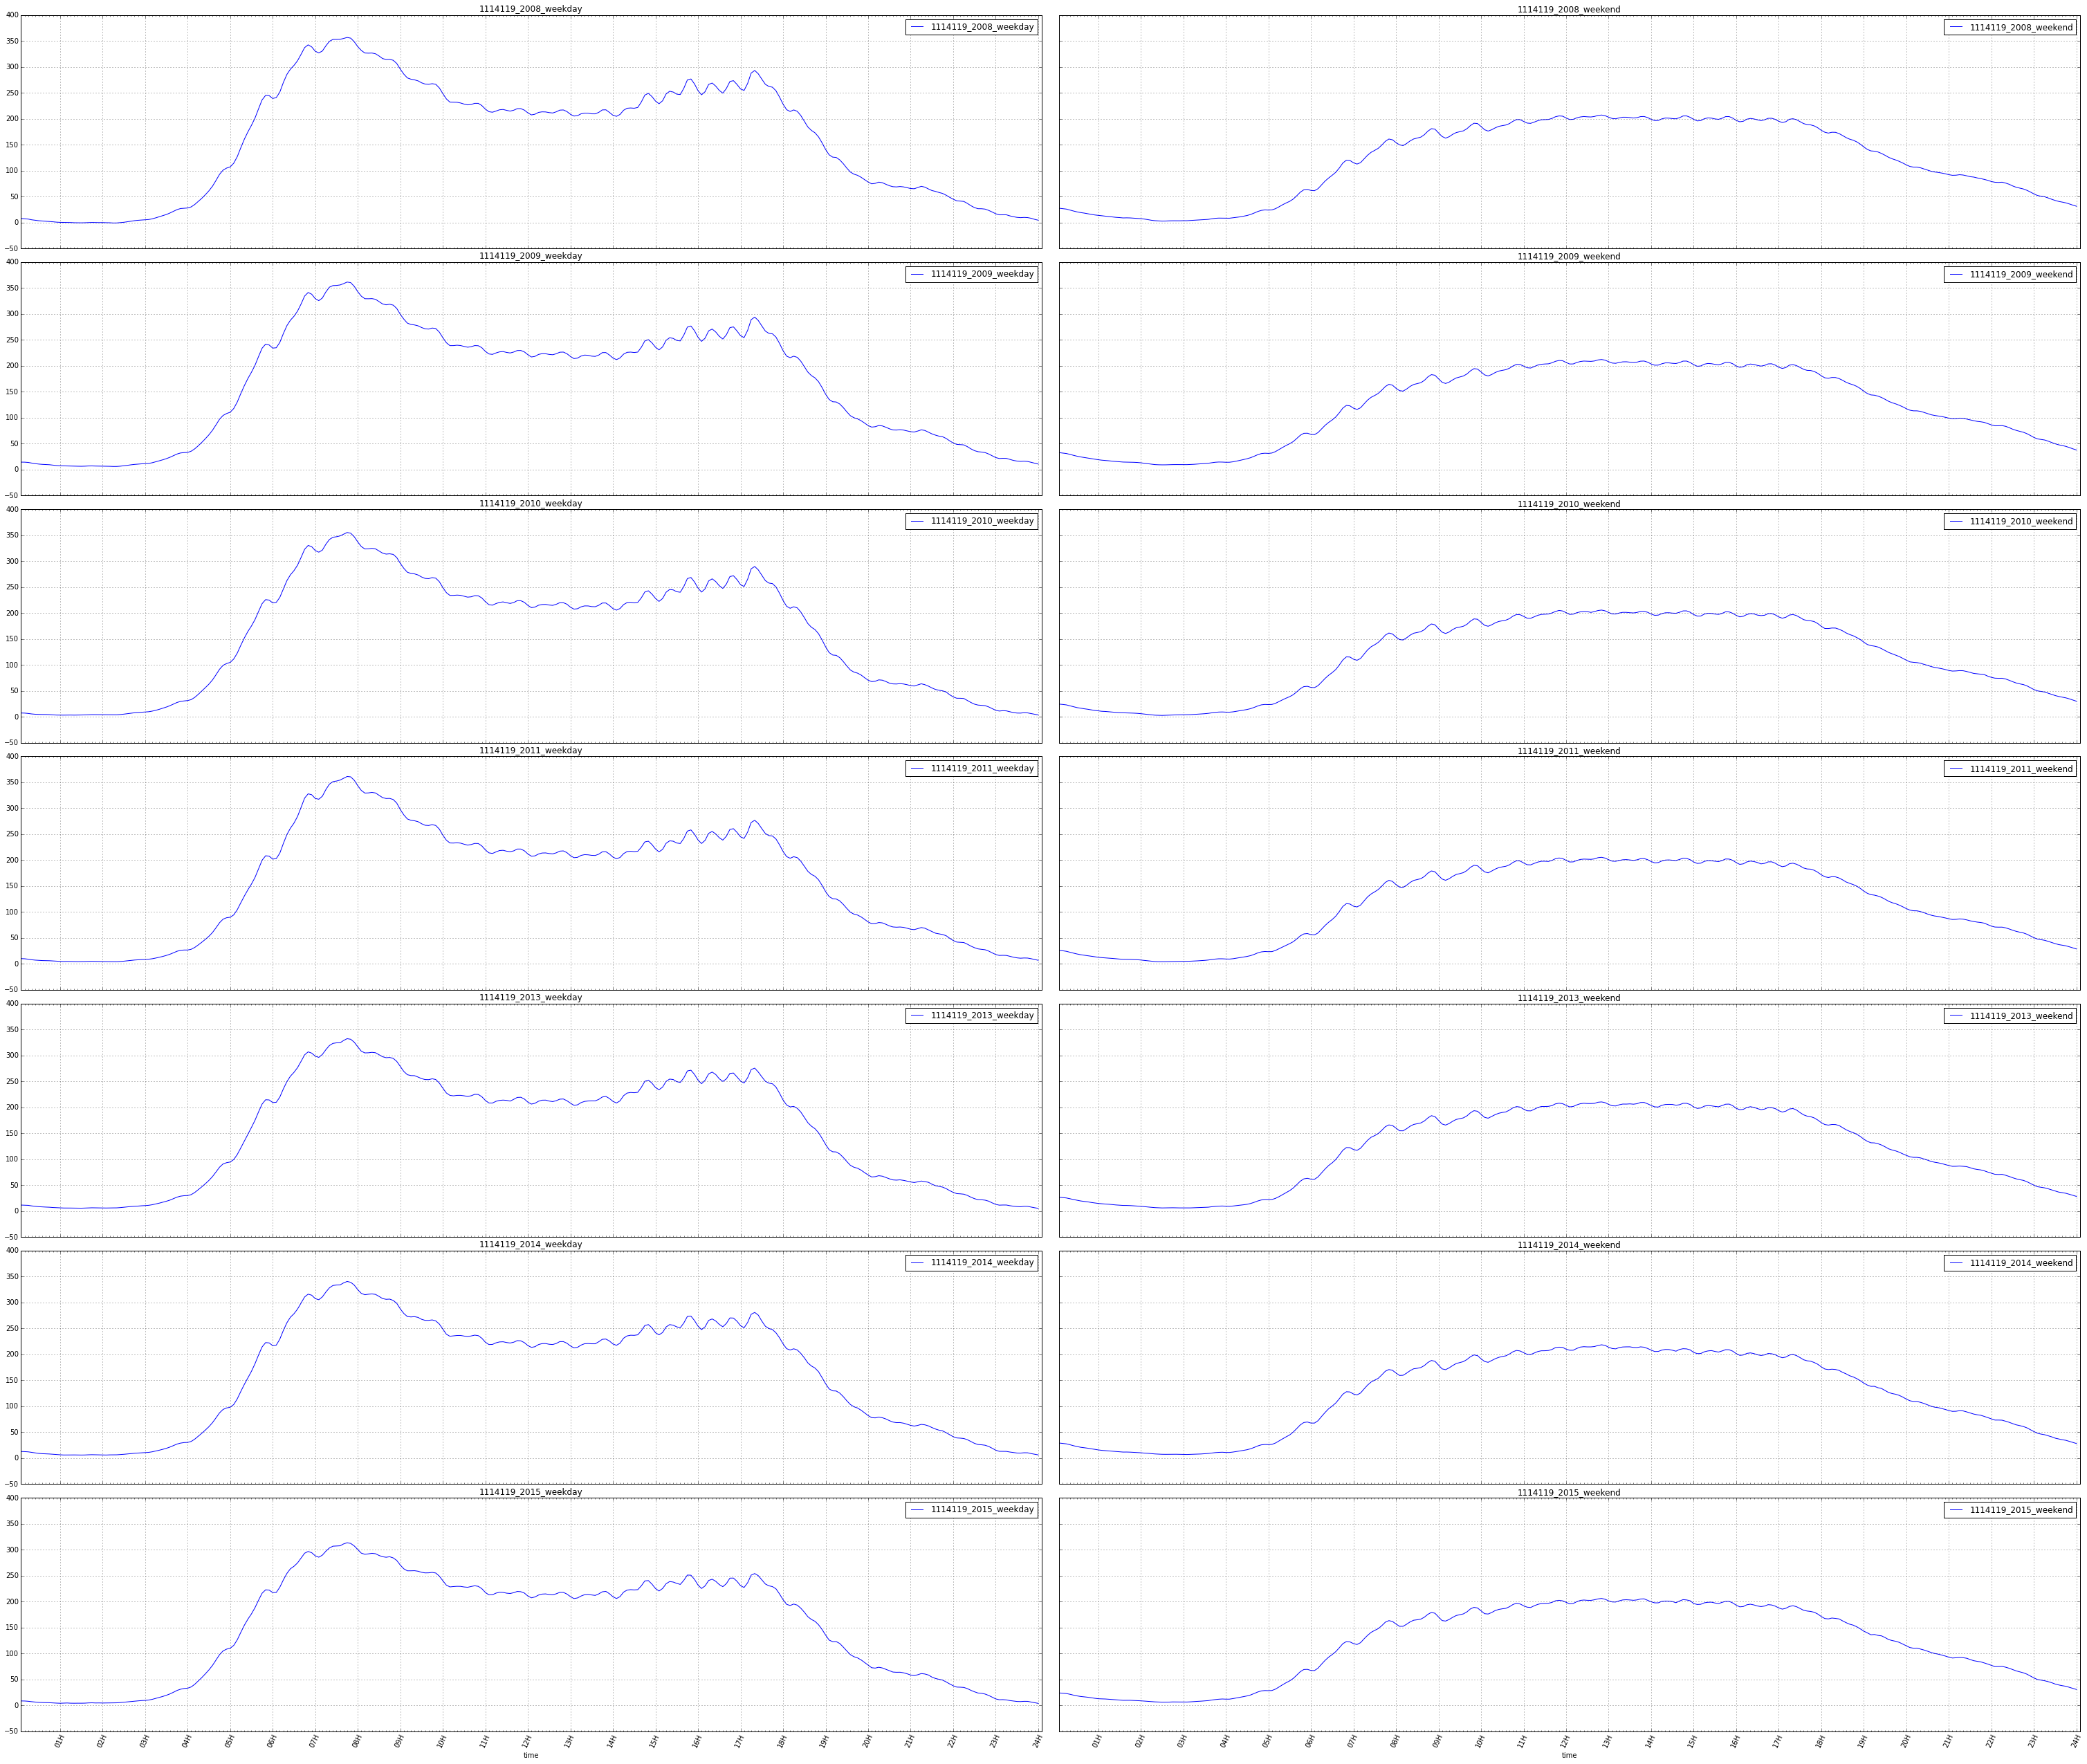

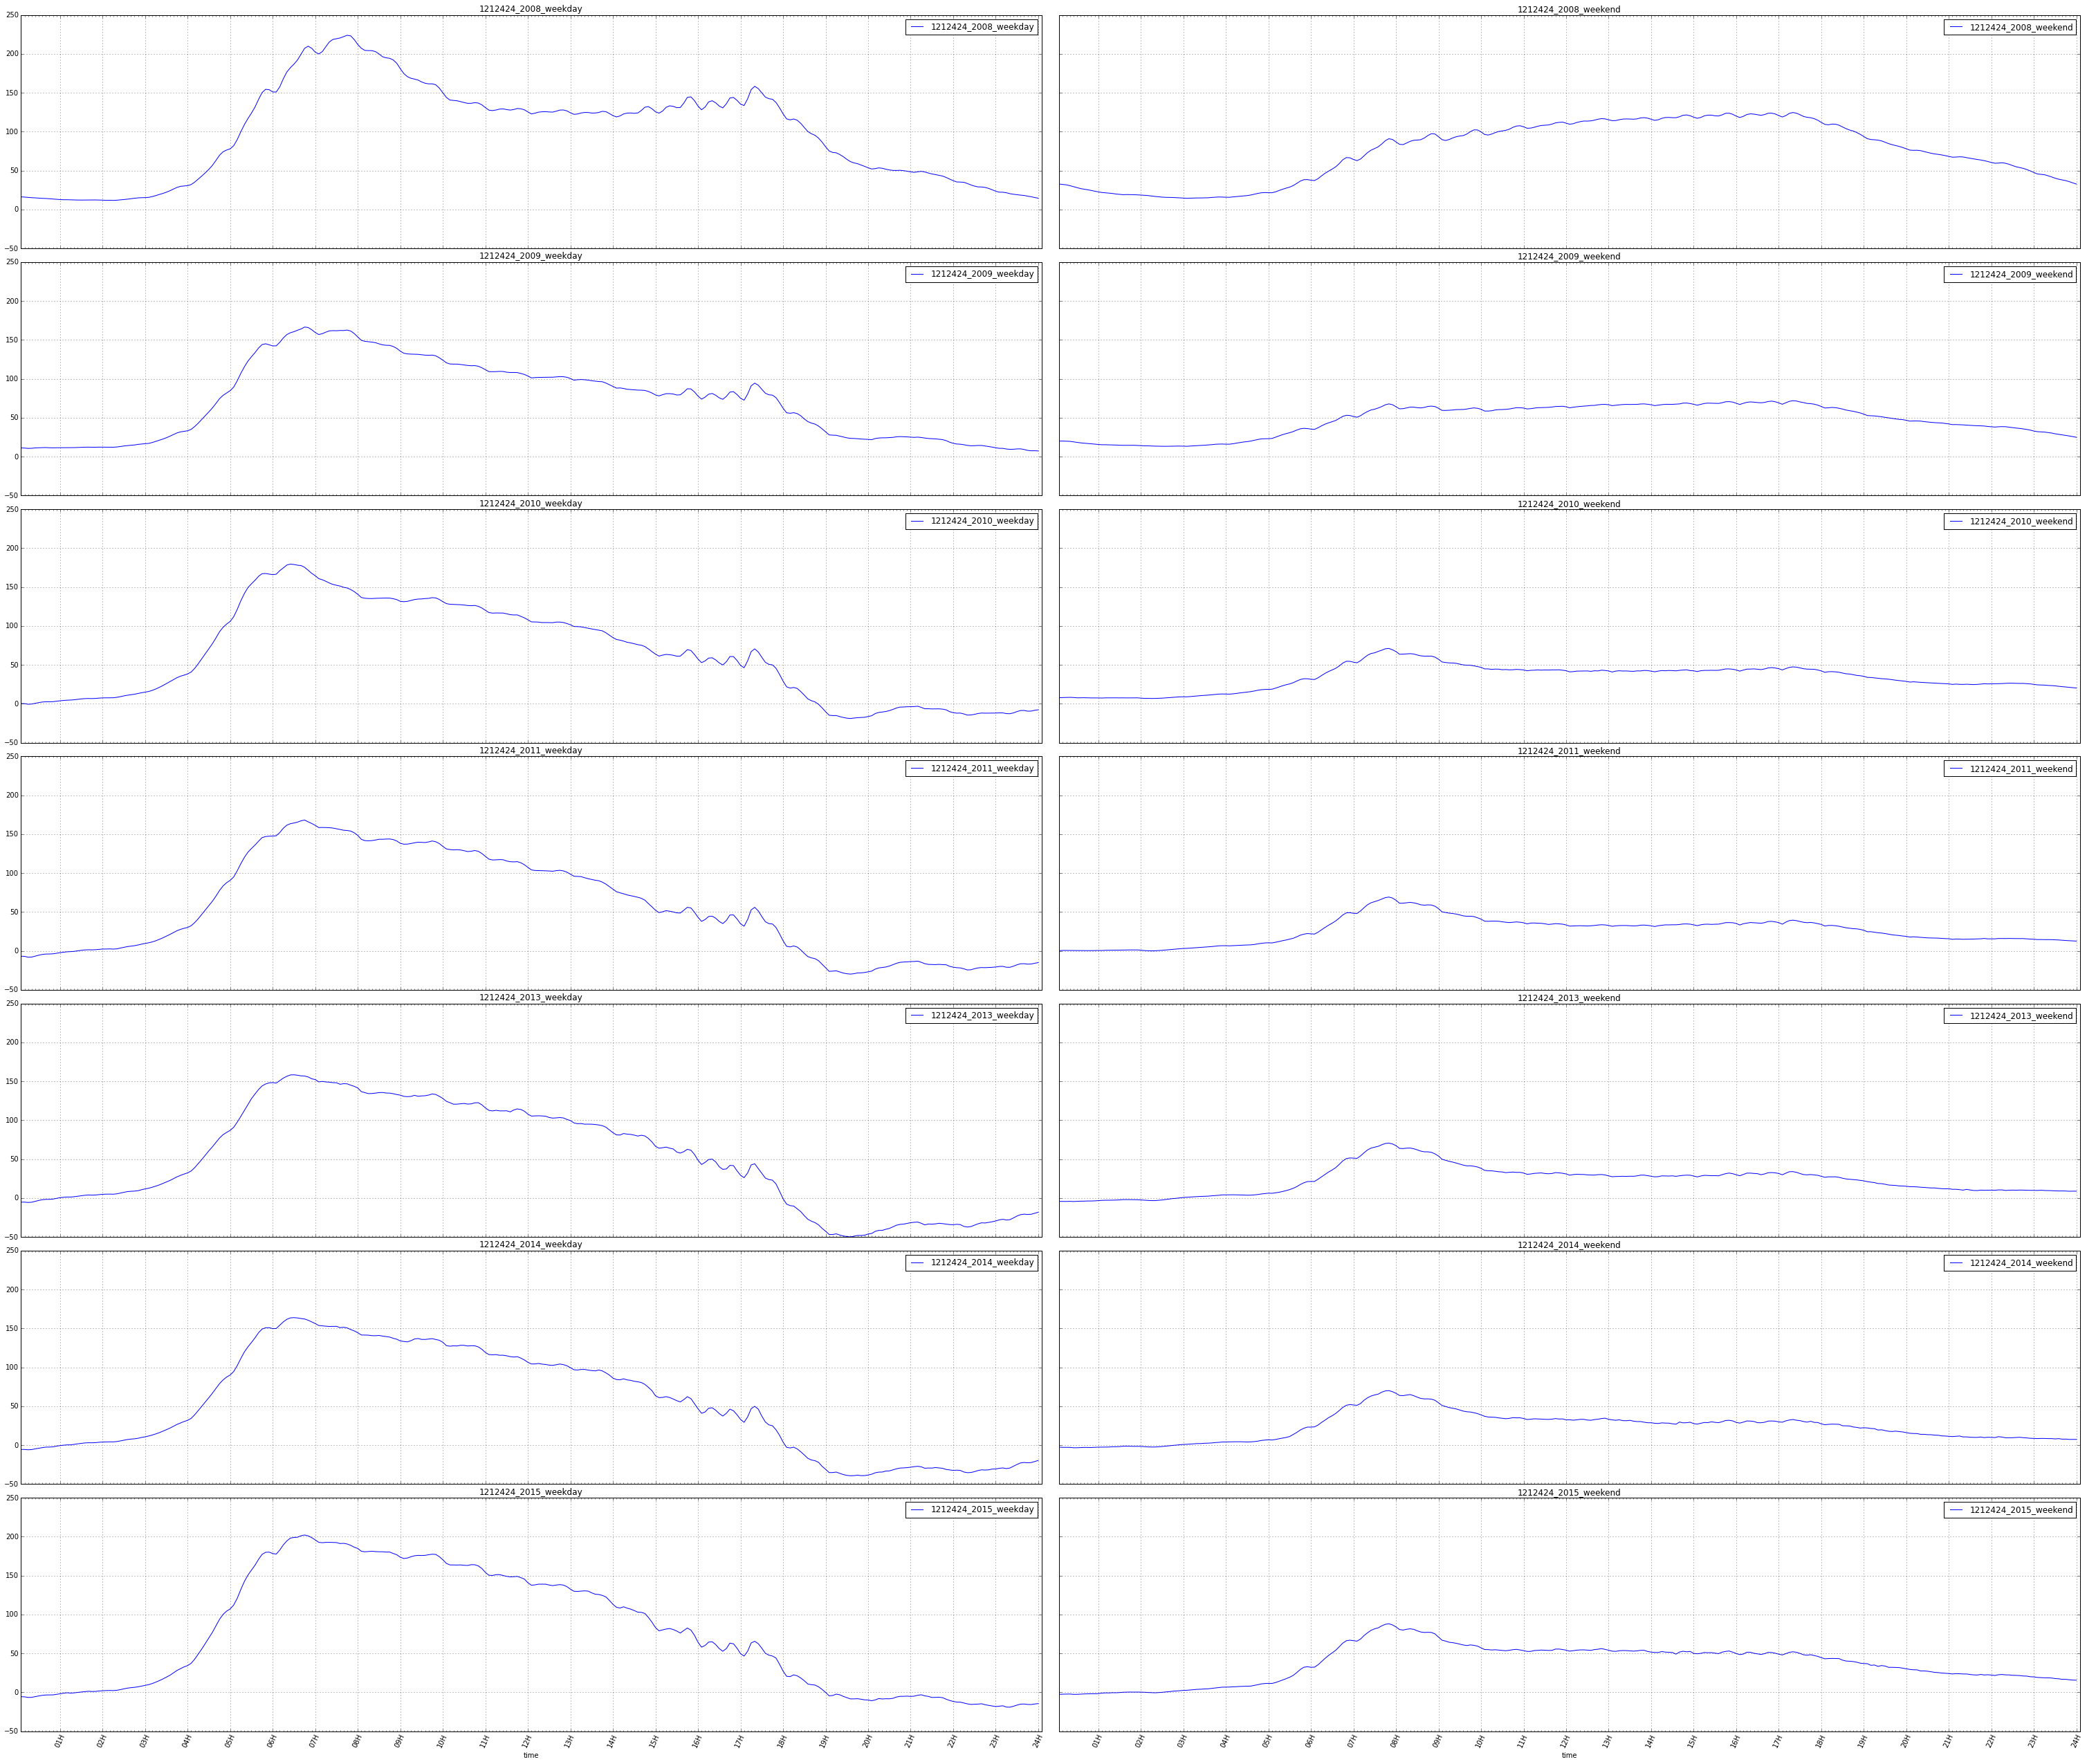

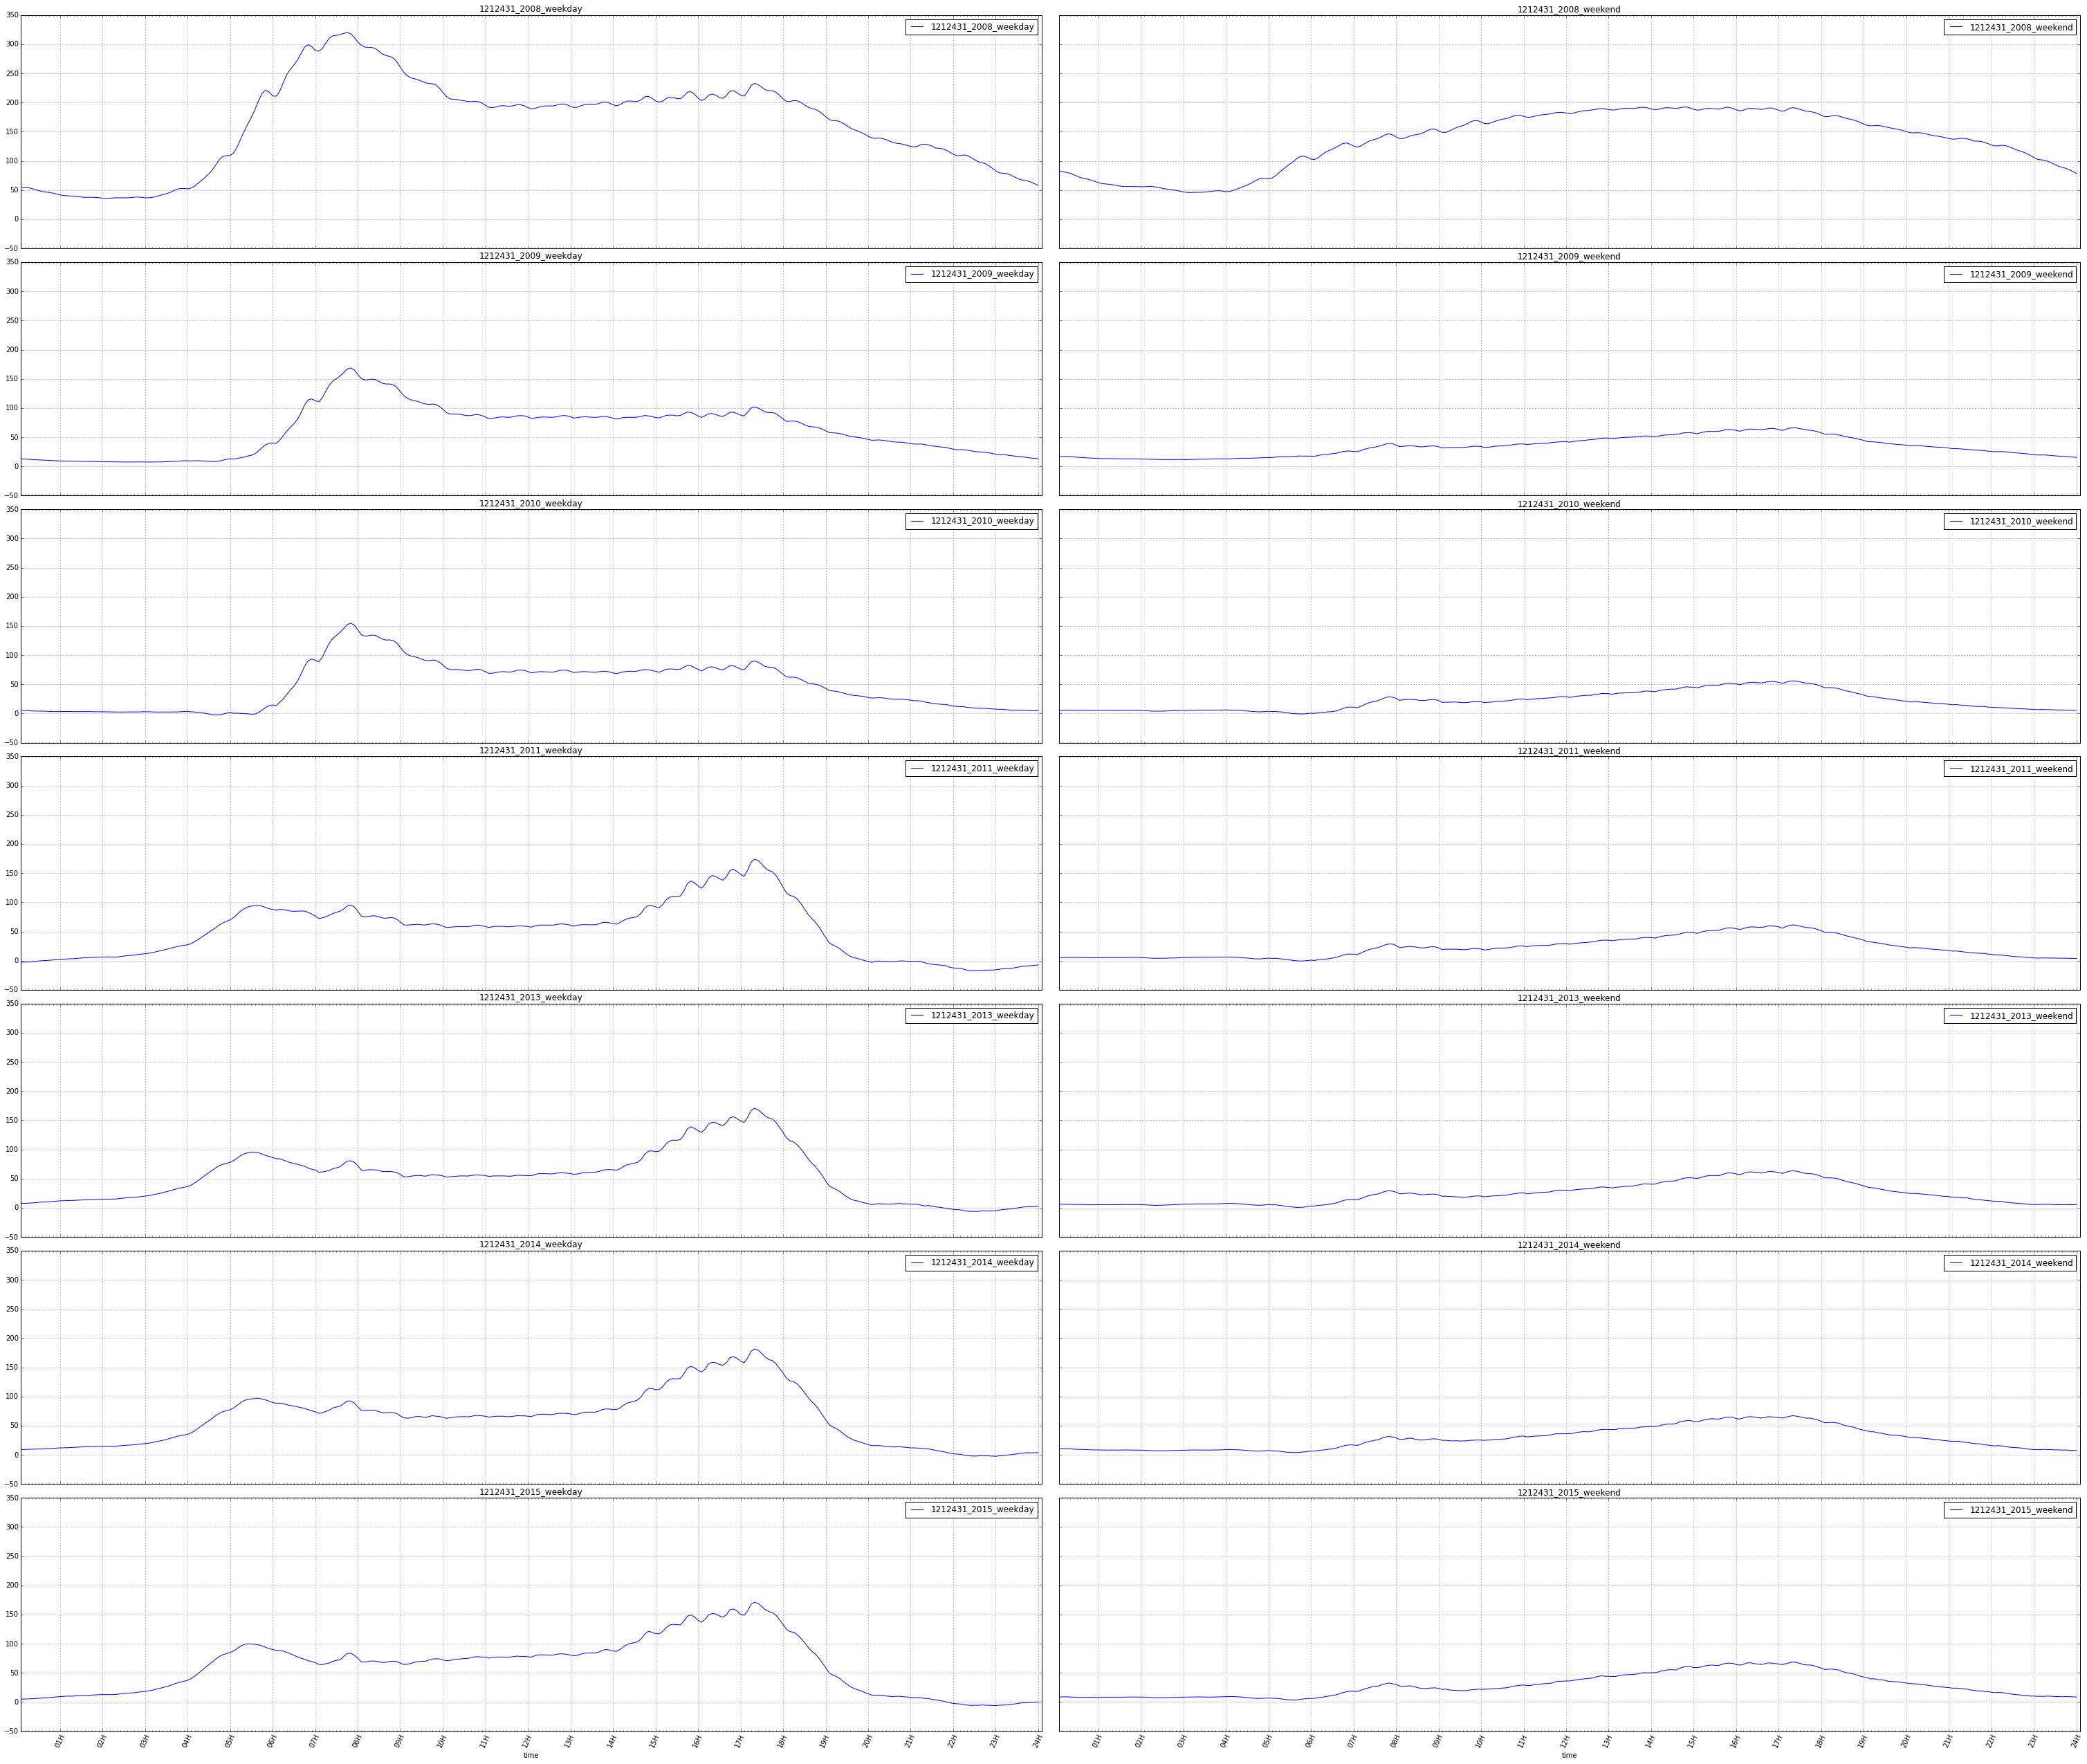

In [24]:
station_ids= [1015810, 1114119, 1212424, 1212431]

rows= 7
columns= 2
for s in station_ids:
    vis_list= visbeans[s]
    j= 0
    
    fig, axes = plt.subplots(nrows=rows, ncols=columns, sharex=True, sharey=True, figsize=(42, 35))
    plt.tight_layout()
    for row in xrange(rows):
        for col in xrange(columns):
            vbean= vis_list[j]
            
            station_label= str(s) + '_' + vbean._token_name
            ax = axes[row, col]
            rec= vbean.get_reconstruction()
            ax.plot(rec, c='b', label=station_label)
            ax.set_xlim([0, len(rec)])
            ax.set_title(station_label)
            ax.legend()
            #
            set_xaxis(ax, len(rec))
            #
            j+=1
            if row == (rows - 1):
                ax.set_xlabel("time")
#     m_output_filename= str(s) + '_reconstruction.pdf'
#     fig.savefig(m_output_filename)